# Player statistics

In [63]:
#imports
import pandas as pd
#import yaml
from datetime import date,datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import json
import glob
import argparse
import datetime, time
import seaborn as sns
from datetime import datetime
import math
import random
from numpy import nan
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict
from collections import Counter
import statsmodels as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.discrete.discrete_model import Probit

In [64]:
#arg parser to dynamically create the analysis for any given game informtion
def create_arg_parser():
    parser = argparse.ArgumentParser(description='Please enter the file path to data source with the -d option. Load a preprocesed dataframe with the -r option.')
    parser.add_argument('-d', type=str, default="./data/T20/men", help='file path to data directory')
    parser.add_argument('-o', type=int, default=20, help='give the number of overs in a game')
    parser.add_argument('-w', type=int, default=10, help='give the number of max wickets in a game')
    parser.add_argument('-r', dest='df', action='store_true', help='reload a preprocessed dataframe as data source')
    parser.set_defaults(df=False)
    return parser
args=create_arg_parser().parse_args("")
over_segments_odi=[0,15,35,40,45,50]
wicket_segments_odi=[[0,0,0,0],[0,3,5,10],[0,4,6,10],[0,4,6,10],[0,5,7,10],[0,6,8,10]]
over_segments_t20=[0,3,6,11,15,18,20]
wicket_segments_t20=[[0,0,0,0],[0,1,3,10],[0,2,4,10],[0,3,5,10],[0,4,6,10],[0,5,7,10]]

over_segments=over_segments_t20
wicket_segments=wicket_segments_t20

if args.o==50: 
    over_segments=over_segments_odi
    wicket_segments=wicket_segments_odi

In [90]:
first=False
if first:
    game_table.to_csv(args.d+"game_table.csv")
else:
    game_table=pd.read_csv(args.d+"game_table.csv")
    game_stat=pd.read_csv(args.d+"game_stats.csv")
    
def preprocess(game_table):
    game_table.start_date=pd.to_datetime(game_table.start_date, format='%Y-%m-%d')
    #game_table.player_dismissed=game_table.player_dismissed.notnull()
    game_table["wicket_scored"]=game_table.wicket_type.notnull()
    game_table["new_no_ball"]=game_table.start_date>datetime(2015,5,7)
    game_table=game_table.sort_values(by="start_date")
    #game_table=game_table[~game_table.match_id.isin(game_stat[-50:].match_id)]
    return game_table
game_table=preprocess(game_table)
df_7=game_table[game_table.start_date>datetime(2012,1,1)]#when using test holdout of last 100 matches
df_7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152343 entries, 39334 to 191522
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Unnamed: 0              152343 non-null  int64         
 1   match_id                152343 non-null  int64         
 2   season                  152343 non-null  object        
 3   start_date              152343 non-null  datetime64[ns]
 4   venue                   152343 non-null  object        
 5   innings                 152343 non-null  int64         
 6   ball                    152343 non-null  float64       
 7   batting_team            152343 non-null  object        
 8   bowling_team            152343 non-null  object        
 9   striker                 152343 non-null  object        
 10  non_striker             152343 non-null  object        
 11  bowler                  152343 non-null  object        
 12  runs_off_bat            15

In [91]:
game_stat

,Unnamed: 0,team_1,team_2,score_1,score_2,wickets_1,wickets_2,balls_played_1,balls_played_2,match_id,start_date
0,0,England,Australia,179,79,8,10,120.0,87.0,211028,2005-06-13
1,1,Australia,New Zealand,214,170,5,10,120.0,120.0,211048,2005-02-17
2,2,South Africa,New Zealand,133,134,10,5,115.0,106.0,222678,2005-10-21
3,3,England,Pakistan,144,148,7,5,120.0,107.0,225263,2006-08-28
4,4,Australia,South Africa,209,114,3,10,119.0,111.0,226374,2006-01-09
...,...,...,...,...,...,...,...,...,...,...,...
814,814,Bulgaria,Romania,128,95,5,10,119.0,102.0,1235829,2020-10-16
815,815,Bulgaria,Romania,60,61,10,4,87.0,57.0,1235832,2020-10-18
816,816,South Africa,England,179,183,6,5,118.0,111.0,1237122,2020-11-27
817,817,South Africa,England,146,147,6,6,116.0,119.0,1237123,2020-11-29


In [92]:
game_table

,Unnamed: 0,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,...,player_dismissed,other_wicket_type,other_player_dismissed,balls_remain,wickets_remain,rr,s_r,rrr,wicket_scored,new_no_ball
0,215,211048,2004/05,2005-02-17,Eden Park,1,0.1,Australia,New Zealand,AC Gilchrist,...,NaN,NaN,NaN,120.0,10.0,0.000000,0.0,0.000000,False,False
156,371,211048,2004/05,2005-02-17,Eden Park,2,5.3,New Zealand,Australia,BB McCullum,...,NaN,NaN,NaN,88.0,8.0,1.600000,30.0,2.208791,False,False
157,372,211048,2004/05,2005-02-17,Eden Park,2,5.4,New Zealand,Australia,BB McCullum,...,NaN,NaN,NaN,87.0,8.0,1.551515,30.0,2.284091,False,False
158,373,211048,2004/05,2005-02-17,Eden Park,2,5.5,New Zealand,Australia,SB Styris,...,NaN,NaN,NaN,86.0,8.0,1.535294,0.0,2.298851,False,False
159,374,211048,2004/05,2005-02-17,Eden Park,2,5.6,New Zealand,Australia,SB Styris,...,NaN,NaN,NaN,85.0,8.0,1.548571,2.0,2.302326,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191366,190238,1233961,2020/21,2020-12-22,McLean Park,1,14.2,New Zealand,Pakistan,DP Conway,...,NaN,NaN,NaN,36.0,6.0,1.354352,22.0,0.000000,False,True
191367,190239,1233961,2020/21,2020-12-22,McLean Park,1,14.3,New Zealand,Pakistan,DP Conway,...,NaN,NaN,NaN,35.0,6.0,1.385477,26.0,0.000000,False,True
191368,190240,1233961,2020/21,2020-12-22,McLean Park,1,14.4,New Zealand,Pakistan,DP Conway,...,NaN,NaN,NaN,34.0,6.0,1.415879,30.0,0.000000,False,True
191339,190211,1233961,2020/21,2020-12-22,McLean Park,1,9.5,New Zealand,Pakistan,GD Phillips,...,NaN,NaN,NaN,62.0,7.0,1.351918,7.0,0.000000,False,True


In [120]:
def get_stats(df):
    striker=pd.DataFrame()    
    #batter stats
    s=df.groupby(['striker'])
    striker["name"]=s['ball'].count().reset_index().striker  
    striker["balls"]=s['ball'].count().reset_index().ball
    striker["games_striker"]=s['match_id'].nunique().reset_index().match_id
    striker["runs"]=s['runs_off_bat'].sum().reset_index().runs_off_bat
    striker["dismissed"]=s['wicket_scored'].sum().reset_index().wicket_scored
    striker["4s"]=s['runs_off_bat'].agg(lambda x: (x==4).sum()).reset_index().runs_off_bat
    striker["6s"]=s['runs_off_bat'].agg(lambda x: (x==6).sum()).reset_index().runs_off_bat
    striker["50s"]=(s['runs_off_bat'].sum()>50).reset_index().runs_off_bat
    striker["100s"]=(s['runs_off_bat'].sum()>100).reset_index().runs_off_bat
    striker["extras_striker"]=s['extras'].sum().reset_index().extras
    #bowler stats
    bowler=pd.DataFrame()
    b=df.groupby(['bowler'])
    bowler["name"]=b['ball'].count().reset_index().bowler
    bowler["games_bowler"]=s['match_id'].nunique().reset_index().match_id
    bowler["balls_bowl"]=b['ball'].count().reset_index().ball
    bowler["concived_runs"]=b['runs_off_bat'].sum().reset_index().runs_off_bat
    bowler["wickets"]=b['wicket_scored'].sum().reset_index().wicket_scored
    bowler["noballs"]=b['noballs'].sum().reset_index().noballs
    bowler["wides"]=b['wides'].sum().reset_index().wides
    bowler["extras_bowler"]=b['extras'].sum().reset_index().extras
    #central metrics
    striker["s_r"]=striker["runs"]/striker["balls"]*100
    striker["Av"]=striker.apply(lambda x: calc_bet_avg(x),axis=1)
    bowler["e_r"]=bowler["concived_runs"]/((bowler["balls_bowl"]-b["extras"].sum().reset_index().extras)/6)
    player=striker.merge(bowler,on="name",how="outer")
    player=player.set_index("name")
    player=player.transpose()
    #player=player.sort_values(by="name")
    return player
    
def calc_bet_avg(player):
    if player.dismissed>0:
        return player["runs"]/player["dismissed"]
    return player["runs"]

players=get_stats(game_table)
players

name,A Ahmadhel,A Ashokan,A Bagai,A Balbirnie,A Bhagwat,A Bhattarai,A Bohara,A Bulow,A Dananjaya,A Flintoff,...,TC Vine,Tanvir Ahmed (1),UKPW Kumaranayaka,Usman Qadir,WT Mashinge,Waqas Maqsood,YA Abdulla,Yamin Ahmadzai,Yasir Shah,Zulqarnain Haider (2)
balls,8,30,157,564,9,3,20,13,56,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
games_striker,1,1,4,30,3,1,5,1,10,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
runs,2,23,165,744,2,2,17,11,44,68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dismissed,1,1,4,27,3,1,4,1,7,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4s,0,2,14,87,0,0,1,0,5,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6s,0,0,0,12,0,0,1,1,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50s,False,False,True,True,False,False,False,False,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100s,False,False,True,True,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
extras_striker,2,0,4,18,0,0,1,2,2,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_r,25,76.6667,105.096,131.915,22.2222,66.6667,85,84.6154,78.5714,117.241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
stats_list=players.transpose()
stats_list

,balls,games_striker,runs,dismissed,4s,6s,50s,100s,extras_striker,s_r,Av,games_bowler,balls_bowl,concived_runs,wickets,noballs,wides,extras_bowler,e_r
name,,,,,,,,,,,,,,,,,,,
A Ahmadhel,8,1,2,1,0,0,False,False,2,25,2,1,5,4,1,0,2,2,8
A Ashokan,30,1,23,1,2,0,False,False,0,76.6667,23,1,19,35,0,0,1,1,11.6667
A Bagai,157,4,165,4,14,0,True,True,4,105.096,41.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Balbirnie,564,30,744,27,87,12,True,True,18,131.915,27.5556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bhagwat,9,3,2,3,0,0,False,False,0,22.2222,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Waqas Maqsood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,11,21,2,0,0,0,11.4545
YA Abdulla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,45,41,2,0,3,3,5.85714
Yamin Ahmadzai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,26,32,3,0,2,3,8.34783


In [115]:
players=players.transpose()
print(np.nanmean(players.s_r.astype("float")))
print(np.nanmean(players.Av.astype("float")))
print(np.nanmean(players.e_r.astype("float")))
players=players.transpose()

94.57334002573742
14.854228856019041
7.929430173599665


In [116]:
stats_mean=defaultdict()
for m in stats_list.columns:
    stats_mean[m]=np.mean(stats_list[m])
np.save(args.d+"player_metrics_mean.npy",stats_mean)
stats_mean

defaultdict(None,
            {'balls': 123.00770712909441,
             'games_striker': 8.38150289017341,
             'runs': 143.46371226718048,
             'dismissed': 6.732819524727039,
             '4s': 12.355812459858702,
             '6s': 4.973025048169557,
             '50s': 0.4271034039820167,
             '100s': 0.29030186255619783,
             'extras_striker': 8.310211946050096,
             's_r': 94.5733400257375,
             'Av': 14.854228856019038,
             'games_bowler': 8.307961504811898,
             'balls_bowl': 167.56167979002623,
             'concived_runs': 195.42694663167103,
             'wickets': 9.171478565179353,
             'noballs': 0.7025371828521435,
             'wides': 6.111111111111111,
             'extras_bowler': 11.32020997375328,
             'e_r': 7.929430173599657})

In [117]:
#read in match data
#sort by match_ids
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def create_match_table(args,players):
    stats=defaultdict()
    for m in list(players.index):
        stats[m]=pd.DataFrame()
        stats[m]["name"]=players.columns
    all_files = sorted(glob.glob(args.d + "/*.csv"), key=numericalSort)
    for filename in tqdm(all_files):
        print()
        #print(i,len(all_files))
        with open(filename, 'r') as f:
            df = preprocess(pd.read_csv(f))
            if len(df)<args.o*6:
                continue
            df_1=df[df.innings==1]
            df_2=df[df.innings!=1]
            m_id=df_1.match_id[0]
            date=df_1.start_date[0]
            team_1=df_1.batting_team[0]
            team_2=df_1.bowling_team[0]
            score_1=df_1.runs_off_bat.sum()+df_1.extras.sum()
            score_2=df_2.runs_off_bat.sum()+df_2.extras.sum()
            wickets_1=df_1.player_dismissed.notnull().sum()
            wickets_2=df_2.player_dismissed.notnull().sum()
            overs_1=len(df_1)-df_1["noballs"].sum()-df_1["wides"].sum()
            overs_2=len(df_2)-df_2["noballs"].sum()-df_2["wides"].sum()
            if score_2<score_1 and wickets_2<args.w and args.o*6-overs_2>0:
                continue
            game_stats=get_stats(df)
            #make a pndas df for each metric
            temp_stats=defaultdict()
            for m in list(game_stats.index):
                temp_stats[m]=[]
            for i in players.columns:
                if i in game_stats.columns:
                    for m in list(stats.keys()):
                        temp_stats[m].append(game_stats[i][m])
                else:
                    for m in list(stats.keys()):
                        temp_stats[m].append(np.nan)
            for m in list(stats.keys()):
                stats[m][df.start_date[0]]=temp_stats[m]
    for m in list(stats.keys()):
        stats[m]=stats[m].set_index("name")
        print(stats[m])
    return stats
player_stats=create_match_table(args,players)
player_stats

  0%|                                                                                          | 0/966 [00:00<?, ?it/s]

  0%|                                                                                  | 1/966 [00:00<07:53,  2.04it/s]

  0%|▏                                                                                 | 2/966 [00:01<08:04,  1.99it/s]

  0%|▎                                                                                 | 3/966 [00:01<08:15,  1.94it/s]

  1%|▍                                                                                 | 5/966 [00:02<06:27,  2.48it/s]

  1%|▌                                                                                 | 6/966 [00:02<06:57,  2.30it/s]

  1%|▌                                                                                 | 7/966 [00:03<08:06,  1.97it/s]

  1%|▋                                                                                 | 8/966 [00:03<08:00,  1.99it/s]

  1%|▊                                                                                 | 9/966 [00:04<08:04,  1.97it/s]

  1%|▉                                                                                | 11/966 [00:04<06:59,  2.28it/s]

  1%|█                                                                                | 12/966 [00:05<07:37,  2.08it/s]

  1%|█▏                                                                               | 14/966 [00:06<06:46,  2.34it/s]

  2%|█▎                                                                               | 15/966 [00:06<06:59,  2.27it/s]

  2%|█▎                                                                               | 16/966 [00:07<07:43,  2.05it/s]

  2%|█▍                                                                               | 17/966 [00:07<07:53,  2.00it/s]

  2%|█▌                                                                               | 18/966 [00:08<08:10,  1.93it/s]

  2%|█▌                                                                               | 19/966 [00:09<08:58,  1.76it/s]

  2%|█▋                                                                               | 20/966 [00:09<09:01,  1.75it/s]

  2%|█▊                                                                               | 22/966 [00:10<07:43,  2.04it/s]

  2%|█▉                                                                               | 23/966 [00:10<07:35,  2.07it/s]

  2%|██                                                                               | 24/966 [00:11<07:26,  2.11it/s]

  3%|██                                                                               | 25/966 [00:11<07:10,  2.19it/s]

  3%|██▏                                                                              | 26/966 [00:12<07:38,  2.05it/s]

  3%|██▎                                                                              | 27/966 [00:12<07:56,  1.97it/s]

  3%|██▎                                                                              | 28/966 [00:13<08:07,  1.92it/s]

  3%|██▍                                                                              | 29/966 [00:13<08:17,  1.88it/s]

  3%|██▌                                                                              | 30/966 [00:14<08:25,  1.85it/s]

  3%|██▌                                                                              | 31/966 [00:14<08:05,  1.93it/s]

  3%|██▋                                                                              | 32/966 [00:15<07:59,  1.95it/s]

  3%|██▊                                                                              | 33/966 [00:15<07:59,  1.95it/s]

  4%|██▉                                                                              | 35/966 [00:16<06:45,  2.30it/s]

  4%|███                                                                              | 36/966 [00:16<07:03,  2.19it/s]

  4%|███▏                                                                             | 38/966 [00:17<06:05,  2.54it/s]

  4%|███▎                                                                             | 39/966 [00:17<06:21,  2.43it/s]

  4%|███▎                                                                             | 40/966 [00:18<06:53,  2.24it/s]

  4%|███▍                                                                             | 41/966 [00:18<07:08,  2.16it/s]

  4%|███▌                                                                             | 42/966 [00:19<08:08,  1.89it/s]

  4%|███▌                                                                             | 43/966 [00:19<07:54,  1.94it/s]

  5%|███▋                                                                             | 44/966 [00:20<07:35,  2.03it/s]

  5%|███▊                                                                             | 45/966 [00:20<07:18,  2.10it/s]

  5%|███▊                                                                             | 46/966 [00:21<07:30,  2.04it/s]

  5%|███▉                                                                             | 47/966 [00:21<07:24,  2.07it/s]

  5%|████                                                                             | 48/966 [00:22<07:38,  2.00it/s]

  5%|████                                                                             | 49/966 [00:22<07:24,  2.06it/s]

  5%|████▎                                                                            | 51/966 [00:23<06:18,  2.42it/s]

  5%|████▎                                                                            | 52/966 [00:23<06:27,  2.36it/s]

  5%|████▍                                                                            | 53/966 [00:24<06:36,  2.30it/s]

  6%|████▋                                                                            | 56/966 [00:24<04:56,  3.07it/s]

  6%|████▊                                                                            | 57/966 [00:25<05:37,  2.69it/s]

  6%|████▊                                                                            | 58/966 [00:25<06:12,  2.44it/s]

  6%|████▉                                                                            | 59/966 [00:26<06:41,  2.26it/s]

  6%|█████                                                                            | 60/966 [00:26<06:41,  2.26it/s]

  6%|█████                                                                            | 61/966 [00:27<06:45,  2.23it/s]

  6%|█████▏                                                                           | 62/966 [00:27<07:07,  2.11it/s]

  7%|█████▎                                                                           | 63/966 [00:28<07:01,  2.14it/s]

  7%|█████▎                                                                           | 64/966 [00:28<06:55,  2.17it/s]

  7%|█████▌                                                                           | 66/966 [00:29<06:01,  2.49it/s]

  7%|█████▌                                                                           | 67/966 [00:29<06:12,  2.41it/s]

  7%|█████▋                                                                           | 68/966 [00:30<06:17,  2.38it/s]

  7%|█████▊                                                                           | 69/966 [00:30<06:21,  2.35it/s]

  7%|█████▊                                                                           | 70/966 [00:30<06:32,  2.28it/s]

  7%|█████▉                                                                           | 71/966 [00:31<06:36,  2.26it/s]

  7%|██████                                                                           | 72/966 [00:31<06:38,  2.24it/s]

  8%|██████                                                                           | 73/966 [00:32<06:35,  2.26it/s]

  8%|██████▏                                                                          | 74/966 [00:32<06:31,  2.28it/s]

  8%|██████▎                                                                          | 76/966 [00:33<05:45,  2.57it/s]

  8%|██████▍                                                                          | 77/966 [00:33<05:52,  2.52it/s]

  8%|██████▌                                                                          | 78/966 [00:34<06:08,  2.41it/s]

  8%|██████▌                                                                          | 79/966 [00:34<06:08,  2.41it/s]

  8%|██████▊                                                                          | 81/966 [00:35<05:32,  2.66it/s]

  8%|██████▉                                                                          | 82/966 [00:35<06:04,  2.42it/s]

  9%|██████▉                                                                          | 83/966 [00:36<06:18,  2.34it/s]

  9%|███████▏                                                                         | 85/966 [00:36<05:32,  2.65it/s]

  9%|███████▏                                                                         | 86/966 [00:37<06:14,  2.35it/s]

  9%|███████▍                                                                         | 88/966 [00:37<05:26,  2.69it/s]

  9%|███████▍                                                                         | 89/966 [00:38<05:59,  2.44it/s]

  9%|███████▌                                                                         | 90/966 [00:38<06:07,  2.38it/s]

  9%|███████▋                                                                         | 91/966 [00:39<06:16,  2.33it/s]

 10%|███████▋                                                                         | 92/966 [00:39<06:20,  2.30it/s]

 10%|███████▊                                                                         | 93/966 [00:39<06:34,  2.21it/s]

 10%|███████▉                                                                         | 94/966 [00:40<06:44,  2.16it/s]

 10%|███████▉                                                                         | 95/966 [00:40<06:45,  2.15it/s]

 10%|████████                                                                         | 96/966 [00:41<06:51,  2.11it/s]

 10%|████████▏                                                                        | 97/966 [00:41<06:51,  2.11it/s]

 10%|████████▏                                                                        | 98/966 [00:42<06:47,  2.13it/s]

 10%|████████▎                                                                        | 99/966 [00:42<06:38,  2.17it/s]

 10%|████████▎                                                                       | 101/966 [00:43<05:50,  2.47it/s]

 11%|████████▍                                                                       | 102/966 [00:43<05:59,  2.40it/s]

 11%|████████▌                                                                       | 103/966 [00:44<06:18,  2.28it/s]

 11%|████████▌                                                                       | 104/966 [00:44<06:23,  2.25it/s]

 11%|████████▋                                                                       | 105/966 [00:45<06:29,  2.21it/s]

 11%|████████▊                                                                       | 106/966 [00:45<06:36,  2.17it/s]

 11%|████████▊                                                                       | 107/966 [00:46<06:34,  2.18it/s]

 11%|████████▉                                                                       | 108/966 [00:46<06:30,  2.19it/s]

 11%|█████████                                                                       | 109/966 [00:47<06:29,  2.20it/s]

 11%|█████████                                                                       | 110/966 [00:47<06:43,  2.12it/s]

 11%|█████████▏                                                                      | 111/966 [00:47<06:32,  2.18it/s]

 12%|█████████▎                                                                      | 112/966 [00:48<06:33,  2.17it/s]

 12%|█████████▎                                                                      | 113/966 [00:48<06:26,  2.21it/s]

 12%|█████████▌                                                                      | 115/966 [00:49<05:41,  2.49it/s]

 12%|█████████▊                                                                      | 118/966 [00:49<04:20,  3.26it/s]

 12%|█████████▉                                                                      | 120/966 [00:50<04:11,  3.36it/s]

 13%|██████████                                                                      | 121/966 [00:50<04:48,  2.93it/s]

 13%|██████████                                                                      | 122/966 [00:51<05:24,  2.60it/s]

 13%|██████████▏                                                                     | 123/966 [00:51<05:36,  2.50it/s]

 13%|██████████▎                                                                     | 124/966 [00:52<05:55,  2.37it/s]

 13%|██████████▎                                                                     | 125/966 [00:52<05:53,  2.38it/s]

 13%|██████████▍                                                                     | 126/966 [00:53<06:14,  2.24it/s]

 13%|██████████▌                                                                     | 127/966 [00:53<06:12,  2.25it/s]

 13%|██████████▌                                                                     | 128/966 [00:54<06:13,  2.24it/s]

 13%|██████████▋                                                                     | 129/966 [00:54<06:08,  2.27it/s]

 13%|██████████▊                                                                     | 130/966 [00:55<06:38,  2.10it/s]

 14%|██████████▊                                                                     | 131/966 [00:55<06:42,  2.08it/s]

 14%|██████████▉                                                                     | 132/966 [00:56<07:05,  1.96it/s]

 14%|███████████                                                                     | 133/966 [00:56<06:54,  2.01it/s]

 14%|███████████                                                                     | 134/966 [00:57<07:23,  1.87it/s]

 14%|███████████▏                                                                    | 135/966 [00:57<07:34,  1.83it/s]

 14%|███████████▎                                                                    | 136/966 [00:58<07:32,  1.83it/s]

 14%|███████████▎                                                                    | 137/966 [00:58<07:09,  1.93it/s]

 14%|███████████▍                                                                    | 138/966 [00:59<06:59,  1.97it/s]

 14%|███████████▌                                                                    | 139/966 [00:59<06:48,  2.02it/s]

 14%|███████████▌                                                                    | 140/966 [01:00<06:48,  2.02it/s]

 15%|███████████▋                                                                    | 141/966 [01:00<06:37,  2.07it/s]

 15%|███████████▊                                                                    | 142/966 [01:01<06:25,  2.14it/s]

 15%|███████████▊                                                                    | 143/966 [01:01<06:29,  2.11it/s]

 15%|████████████                                                                    | 146/966 [01:02<05:18,  2.58it/s]

 15%|████████████▏                                                                   | 147/966 [01:02<05:37,  2.43it/s]

 15%|████████████▎                                                                   | 149/966 [01:03<04:57,  2.75it/s]

 16%|████████████▍                                                                   | 150/966 [01:03<05:31,  2.46it/s]

 16%|████████████▌                                                                   | 151/966 [01:04<05:43,  2.37it/s]

 16%|████████████▌                                                                   | 152/966 [01:04<07:06,  1.91it/s]

 16%|████████████▋                                                                   | 153/966 [01:05<06:54,  1.96it/s]

 16%|████████████▊                                                                   | 154/966 [01:05<06:44,  2.01it/s]

 16%|████████████▊                                                                   | 155/966 [01:06<06:34,  2.06it/s]

 16%|████████████▉                                                                   | 156/966 [01:06<06:20,  2.13it/s]

 16%|█████████████                                                                   | 157/966 [01:07<06:23,  2.11it/s]

 16%|█████████████                                                                   | 158/966 [01:07<06:17,  2.14it/s]

 16%|█████████████▏                                                                  | 159/966 [01:08<06:11,  2.17it/s]

 17%|█████████████▍                                                                  | 162/966 [01:08<04:34,  2.93it/s]

 17%|█████████████▍                                                                  | 163/966 [01:09<05:22,  2.49it/s]

 17%|█████████████▌                                                                  | 164/966 [01:09<05:33,  2.40it/s]

 17%|█████████████▋                                                                  | 165/966 [01:10<05:44,  2.33it/s]

 17%|█████████████▋                                                                  | 166/966 [01:10<05:58,  2.23it/s]

 17%|█████████████▊                                                                  | 167/966 [01:11<06:05,  2.19it/s]

 17%|█████████████▉                                                                  | 168/966 [01:11<06:01,  2.21it/s]

 18%|██████████████                                                                  | 170/966 [01:12<05:25,  2.45it/s]

 18%|██████████████▏                                                                 | 171/966 [01:12<05:38,  2.35it/s]

 18%|██████████████▏                                                                 | 172/966 [01:13<05:57,  2.22it/s]

 18%|██████████████▎                                                                 | 173/966 [01:13<06:00,  2.20it/s]

 18%|██████████████▍                                                                 | 174/966 [01:14<05:58,  2.21it/s]

 18%|██████████████▍                                                                 | 175/966 [01:14<05:54,  2.23it/s]

 18%|██████████████▌                                                                 | 176/966 [01:15<06:07,  2.15it/s]

 18%|██████████████▋                                                                 | 177/966 [01:15<06:04,  2.17it/s]

 18%|██████████████▋                                                                 | 178/966 [01:15<06:00,  2.19it/s]

 19%|██████████████▊                                                                 | 179/966 [01:16<06:00,  2.18it/s]

 19%|██████████████▉                                                                 | 180/966 [01:16<06:06,  2.14it/s]

 19%|██████████████▉                                                                 | 181/966 [01:17<06:07,  2.14it/s]

 19%|███████████████                                                                 | 182/966 [01:17<06:18,  2.07it/s]

 19%|███████████████▏                                                                | 184/966 [01:18<05:22,  2.43it/s]

 19%|███████████████▎                                                                | 185/966 [01:18<05:25,  2.40it/s]

 19%|███████████████▍                                                                | 186/966 [01:19<05:36,  2.32it/s]

 19%|███████████████▍                                                                | 187/966 [01:19<05:50,  2.22it/s]

 19%|███████████████▌                                                                | 188/966 [01:20<05:59,  2.16it/s]

 20%|███████████████▋                                                                | 190/966 [01:20<05:12,  2.48it/s]

 20%|███████████████▊                                                                | 191/966 [01:21<05:27,  2.37it/s]

 20%|███████████████▉                                                                | 193/966 [01:21<04:48,  2.68it/s]

 20%|████████████████                                                                | 194/966 [01:22<05:12,  2.47it/s]

 20%|████████████████▏                                                               | 195/966 [01:22<05:22,  2.39it/s]

 20%|████████████████▏                                                               | 196/966 [01:23<05:36,  2.29it/s]

 20%|████████████████▎                                                               | 197/966 [01:23<05:42,  2.25it/s]

 21%|████████████████▍                                                               | 199/966 [01:24<04:58,  2.57it/s]

 21%|████████████████▋                                                               | 201/966 [01:24<04:31,  2.82it/s]

 21%|████████████████▋                                                               | 202/966 [01:25<04:54,  2.59it/s]

 21%|████████████████▊                                                               | 203/966 [01:25<05:09,  2.47it/s]

 21%|████████████████▉                                                               | 204/966 [01:26<05:33,  2.29it/s]

 21%|████████████████▉                                                               | 205/966 [01:26<05:31,  2.29it/s]

 21%|█████████████████                                                               | 206/966 [01:27<05:35,  2.27it/s]

 22%|█████████████████▎                                                              | 209/966 [01:27<04:04,  3.09it/s]

 22%|█████████████████▍                                                              | 210/966 [01:28<04:39,  2.70it/s]

 22%|█████████████████▍                                                              | 211/966 [01:28<04:52,  2.58it/s]

 22%|█████████████████▋                                                              | 213/966 [01:29<04:20,  2.89it/s]

 22%|█████████████████▋                                                              | 214/966 [01:29<04:59,  2.51it/s]

 22%|█████████████████▉                                                              | 216/966 [01:30<04:38,  2.70it/s]

 22%|█████████████████▉                                                              | 217/966 [01:30<05:04,  2.46it/s]

 23%|██████████████████                                                              | 218/966 [01:31<05:20,  2.33it/s]

 23%|██████████████████▏                                                             | 219/966 [01:31<05:16,  2.36it/s]

 23%|██████████████████▏                                                             | 220/966 [01:31<05:19,  2.33it/s]

 23%|██████████████████▎                                                             | 221/966 [01:32<05:18,  2.34it/s]

 23%|██████████████████▍                                                             | 222/966 [01:32<05:23,  2.30it/s]

 23%|██████████████████▌                                                             | 224/966 [01:33<04:52,  2.53it/s]

 23%|██████████████████▋                                                             | 225/966 [01:34<05:39,  2.18it/s]

 23%|██████████████████▊                                                             | 227/966 [01:34<04:59,  2.47it/s]

 24%|██████████████████▉                                                             | 228/966 [01:35<05:24,  2.27it/s]

 24%|██████████████████▉                                                             | 229/966 [01:35<05:40,  2.16it/s]

 24%|███████████████████                                                             | 230/966 [01:36<06:02,  2.03it/s]

 24%|███████████████████▎                                                            | 233/966 [01:36<04:56,  2.47it/s]

 24%|███████████████████▍                                                            | 234/966 [01:37<05:22,  2.27it/s]

 24%|███████████████████▍                                                            | 235/966 [01:37<05:55,  2.06it/s]

 24%|███████████████████▌                                                            | 236/966 [01:38<06:05,  2.00it/s]

 25%|███████████████████▋                                                            | 237/966 [01:39<06:19,  1.92it/s]

 25%|███████████████████▋                                                            | 238/966 [01:39<07:19,  1.66it/s]

 25%|███████████████████▊                                                            | 239/966 [01:40<07:50,  1.54it/s]

 25%|███████████████████▉                                                            | 240/966 [01:41<07:25,  1.63it/s]

 25%|███████████████████▉                                                            | 241/966 [01:41<06:56,  1.74it/s]

 25%|████████████████████                                                            | 243/966 [01:42<05:23,  2.23it/s]

 25%|████████████████████▏                                                           | 244/966 [01:42<05:39,  2.12it/s]

 25%|████████████████████▎                                                           | 245/966 [01:43<05:56,  2.02it/s]

 25%|████████████████████▎                                                           | 246/966 [01:43<06:12,  1.93it/s]

 26%|████████████████████▌                                                           | 249/966 [01:44<04:34,  2.61it/s]

 26%|████████████████████▋                                                           | 250/966 [01:45<05:14,  2.28it/s]

 26%|████████████████████▊                                                           | 251/966 [01:45<05:55,  2.01it/s]

 26%|████████████████████▊                                                           | 252/966 [01:46<06:58,  1.70it/s]

 26%|████████████████████▉                                                           | 253/966 [01:47<06:39,  1.78it/s]

 26%|█████████████████████                                                           | 254/966 [01:47<06:34,  1.81it/s]

 26%|█████████████████████                                                           | 255/966 [01:48<06:36,  1.79it/s]

 27%|█████████████████████▎                                                          | 257/966 [01:48<05:38,  2.10it/s]

 27%|█████████████████████▍                                                          | 259/966 [01:49<04:57,  2.37it/s]

 27%|█████████████████████▌                                                          | 260/966 [01:49<05:28,  2.15it/s]

 27%|█████████████████████▋                                                          | 262/966 [01:50<04:48,  2.44it/s]

 27%|█████████████████████▊                                                          | 263/966 [01:51<05:08,  2.28it/s]

 27%|█████████████████████▊                                                          | 264/966 [01:51<05:33,  2.10it/s]

 27%|█████████████████████▉                                                          | 265/966 [01:52<05:42,  2.05it/s]

 28%|██████████████████████                                                          | 266/966 [01:52<05:43,  2.04it/s]

 28%|██████████████████████▏                                                         | 268/966 [01:53<04:58,  2.34it/s]

 28%|██████████████████████▎                                                         | 269/966 [01:53<05:08,  2.26it/s]

 28%|██████████████████████▎                                                         | 270/966 [01:54<05:08,  2.26it/s]

 28%|██████████████████████▍                                                         | 271/966 [01:54<05:18,  2.18it/s]

 28%|██████████████████████▌                                                         | 272/966 [01:55<05:36,  2.06it/s]

 28%|██████████████████████▌                                                         | 273/966 [01:55<05:55,  1.95it/s]

 28%|██████████████████████▊                                                         | 275/966 [01:56<05:24,  2.13it/s]

 29%|██████████████████████▊                                                         | 276/966 [01:57<05:40,  2.03it/s]

 29%|███████████████████████                                                         | 278/966 [01:57<04:54,  2.33it/s]

 29%|███████████████████████                                                         | 279/966 [01:58<05:17,  2.16it/s]

 29%|███████████████████████▎                                                        | 281/966 [01:58<04:34,  2.49it/s]

 29%|███████████████████████▎                                                        | 282/966 [01:59<04:54,  2.32it/s]

 29%|███████████████████████▍                                                        | 283/966 [01:59<04:56,  2.30it/s]

 29%|███████████████████████▌                                                        | 284/966 [02:00<04:57,  2.29it/s]

 30%|███████████████████████▌                                                        | 285/966 [02:00<05:03,  2.24it/s]

 30%|███████████████████████▋                                                        | 286/966 [02:00<05:15,  2.16it/s]

 30%|███████████████████████▊                                                        | 287/966 [02:01<05:11,  2.18it/s]

 30%|███████████████████████▊                                                        | 288/966 [02:01<05:07,  2.21it/s]

 30%|████████████████████████                                                        | 290/966 [02:02<05:10,  2.18it/s]

 30%|████████████████████████                                                        | 291/966 [02:03<05:21,  2.10it/s]

 30%|████████████████████████▏                                                       | 292/966 [02:03<05:26,  2.06it/s]

 30%|████████████████████████▎                                                       | 293/966 [02:04<05:25,  2.06it/s]

 30%|████████████████████████▎                                                       | 294/966 [02:04<05:16,  2.12it/s]

 31%|████████████████████████▌                                                       | 296/966 [02:05<04:34,  2.44it/s]

 31%|████████████████████████▌                                                       | 297/966 [02:05<04:44,  2.35it/s]

 31%|████████████████████████▋                                                       | 298/966 [02:06<04:49,  2.30it/s]

 31%|████████████████████████▊                                                       | 299/966 [02:06<04:51,  2.29it/s]

 31%|████████████████████████▊                                                       | 300/966 [02:07<05:07,  2.17it/s]

 31%|████████████████████████▉                                                       | 301/966 [02:07<05:04,  2.19it/s]

 31%|█████████████████████████                                                       | 302/966 [02:08<05:08,  2.15it/s]

 31%|█████████████████████████                                                       | 303/966 [02:08<05:11,  2.13it/s]

 32%|█████████████████████████▎                                                      | 305/966 [02:09<04:26,  2.48it/s]

 32%|█████████████████████████▎                                                      | 306/966 [02:09<04:30,  2.44it/s]

 32%|█████████████████████████▌                                                      | 308/966 [02:10<04:03,  2.71it/s]

 32%|█████████████████████████▌                                                      | 309/966 [02:10<04:18,  2.54it/s]

 32%|█████████████████████████▋                                                      | 310/966 [02:11<04:46,  2.29it/s]

 32%|█████████████████████████▉                                                      | 313/966 [02:11<04:01,  2.71it/s]

 33%|██████████████████████████                                                      | 314/966 [02:12<04:20,  2.50it/s]

 33%|██████████████████████████▏                                                     | 316/966 [02:12<03:54,  2.77it/s]

 33%|██████████████████████████▎                                                     | 317/966 [02:13<04:14,  2.55it/s]

 33%|██████████████████████████▎                                                     | 318/966 [02:13<04:24,  2.45it/s]

 33%|██████████████████████████▍                                                     | 319/966 [02:14<04:42,  2.29it/s]

 33%|██████████████████████████▌                                                     | 320/966 [02:14<04:46,  2.25it/s]

 33%|██████████████████████████▌                                                     | 321/966 [02:14<04:45,  2.26it/s]

 33%|██████████████████████████▋                                                     | 322/966 [02:15<05:00,  2.14it/s]

 33%|██████████████████████████▋                                                     | 323/966 [02:15<04:59,  2.15it/s]

 34%|██████████████████████████▊                                                     | 324/966 [02:16<04:56,  2.17it/s]

 34%|██████████████████████████▉                                                     | 325/966 [02:16<04:54,  2.18it/s]

 34%|███████████████████████████                                                     | 327/966 [02:17<04:17,  2.48it/s]

 34%|███████████████████████████▏                                                    | 329/966 [02:17<03:47,  2.80it/s]

 34%|███████████████████████████▎                                                    | 330/966 [02:18<04:10,  2.54it/s]

 34%|███████████████████████████▍                                                    | 331/966 [02:18<04:21,  2.43it/s]

 34%|███████████████████████████▍                                                    | 332/966 [02:19<04:26,  2.38it/s]

 34%|███████████████████████████▌                                                    | 333/966 [02:19<04:29,  2.35it/s]

 35%|███████████████████████████▋                                                    | 334/966 [02:20<04:30,  2.33it/s]

 35%|███████████████████████████▋                                                    | 335/966 [02:20<04:33,  2.31it/s]

 35%|███████████████████████████▊                                                    | 336/966 [02:21<04:27,  2.36it/s]

 35%|███████████████████████████▉                                                    | 337/966 [02:21<04:40,  2.25it/s]

 35%|████████████████████████████                                                    | 339/966 [02:22<04:01,  2.59it/s]

 35%|████████████████████████████▏                                                   | 340/966 [02:22<04:21,  2.39it/s]

 35%|████████████████████████████▏                                                   | 341/966 [02:22<04:26,  2.34it/s]

 35%|████████████████████████████▎                                                   | 342/966 [02:23<04:34,  2.28it/s]

 36%|████████████████████████████▍                                                   | 343/966 [02:23<04:29,  2.31it/s]

 36%|████████████████████████████▍                                                   | 344/966 [02:24<04:32,  2.28it/s]

 36%|████████████████████████████▋                                                   | 346/966 [02:24<04:00,  2.58it/s]

 36%|████████████████████████████▋                                                   | 347/966 [02:25<04:09,  2.48it/s]

 36%|████████████████████████████▊                                                   | 348/966 [02:25<04:14,  2.42it/s]

 36%|████████████████████████████▉                                                   | 350/966 [02:26<03:47,  2.71it/s]

 36%|█████████████████████████████                                                   | 351/966 [02:26<04:08,  2.48it/s]

 36%|█████████████████████████████▏                                                  | 352/966 [02:27<04:15,  2.40it/s]

 37%|█████████████████████████████▏                                                  | 353/966 [02:27<04:27,  2.29it/s]

 37%|█████████████████████████████▎                                                  | 354/966 [02:28<04:29,  2.27it/s]

 37%|█████████████████████████████▍                                                  | 355/966 [02:28<04:28,  2.27it/s]

 37%|█████████████████████████████▍                                                  | 356/966 [02:28<04:25,  2.29it/s]

 37%|█████████████████████████████▌                                                  | 357/966 [02:29<04:36,  2.20it/s]

 37%|█████████████████████████████▋                                                  | 358/966 [02:29<04:37,  2.19it/s]

 37%|█████████████████████████████▋                                                  | 359/966 [02:30<04:37,  2.19it/s]

 37%|█████████████████████████████▉                                                  | 361/966 [02:30<03:57,  2.54it/s]

 37%|█████████████████████████████▉                                                  | 362/966 [02:31<04:13,  2.39it/s]

 38%|██████████████████████████████▏                                                 | 364/966 [02:31<03:39,  2.74it/s]

 38%|██████████████████████████████▏                                                 | 365/966 [02:32<03:55,  2.55it/s]

 38%|██████████████████████████████▍                                                 | 367/966 [02:32<03:30,  2.85it/s]

 38%|██████████████████████████████▍                                                 | 368/966 [02:33<03:48,  2.62it/s]

 38%|██████████████████████████████▌                                                 | 369/966 [02:33<04:01,  2.47it/s]

 38%|██████████████████████████████▋                                                 | 370/966 [02:34<04:18,  2.31it/s]

 38%|██████████████████████████████▋                                                 | 371/966 [02:34<04:24,  2.25it/s]

 39%|██████████████████████████████▊                                                 | 372/966 [02:35<04:26,  2.23it/s]

 39%|██████████████████████████████▉                                                 | 373/966 [02:35<04:35,  2.15it/s]

 39%|██████████████████████████████▉                                                 | 374/966 [02:36<04:37,  2.14it/s]

 39%|███████████████████████████████▏                                                | 376/966 [02:36<03:57,  2.48it/s]

 39%|███████████████████████████████▎                                                | 378/966 [02:37<03:32,  2.77it/s]

 39%|███████████████████████████████▍                                                | 379/966 [02:37<03:46,  2.59it/s]

 39%|███████████████████████████████▍                                                | 380/966 [02:38<04:08,  2.36it/s]

 39%|███████████████████████████████▌                                                | 381/966 [02:38<04:15,  2.29it/s]

 40%|███████████████████████████████▋                                                | 382/966 [02:39<04:20,  2.24it/s]

 40%|███████████████████████████████▋                                                | 383/966 [02:39<04:24,  2.21it/s]

 40%|███████████████████████████████▊                                                | 384/966 [02:39<04:24,  2.20it/s]

 40%|███████████████████████████████▉                                                | 385/966 [02:40<04:24,  2.20it/s]

 40%|███████████████████████████████▉                                                | 386/966 [02:40<04:22,  2.21it/s]

 40%|████████████████████████████████                                                | 387/966 [02:41<04:32,  2.12it/s]

 40%|████████████████████████████████▏                                               | 388/966 [02:41<04:37,  2.09it/s]

 40%|████████████████████████████████▏                                               | 389/966 [02:42<04:47,  2.01it/s]

 40%|████████████████████████████████▎                                               | 390/966 [02:42<04:41,  2.05it/s]

 40%|████████████████████████████████▍                                               | 391/966 [02:43<04:36,  2.08it/s]

 41%|████████████████████████████████▍                                               | 392/966 [02:43<04:40,  2.05it/s]

 41%|████████████████████████████████▌                                               | 393/966 [02:44<04:34,  2.09it/s]

 41%|████████████████████████████████▋                                               | 394/966 [02:44<04:28,  2.13it/s]

 41%|████████████████████████████████▋                                               | 395/966 [02:45<04:34,  2.08it/s]

 41%|████████████████████████████████▊                                               | 396/966 [02:45<04:33,  2.08it/s]

 41%|████████████████████████████████▉                                               | 397/966 [02:46<04:30,  2.11it/s]

 41%|████████████████████████████████▉                                               | 398/966 [02:46<04:28,  2.12it/s]

 41%|█████████████████████████████████                                               | 399/966 [02:47<04:30,  2.10it/s]

 41%|█████████████████████████████████▏                                              | 400/966 [02:47<04:26,  2.13it/s]

 42%|█████████████████████████████████▏                                              | 401/966 [02:48<04:32,  2.07it/s]

 42%|█████████████████████████████████▎                                              | 402/966 [02:48<04:28,  2.10it/s]

 42%|█████████████████████████████████▎                                              | 403/966 [02:49<04:23,  2.14it/s]

 42%|█████████████████████████████████▍                                              | 404/966 [02:49<04:18,  2.17it/s]

 42%|█████████████████████████████████▌                                              | 405/966 [02:49<04:26,  2.10it/s]

 42%|█████████████████████████████████▌                                              | 406/966 [02:50<04:20,  2.15it/s]

 42%|█████████████████████████████████▋                                              | 407/966 [02:50<04:15,  2.18it/s]

 42%|█████████████████████████████████▊                                              | 408/966 [02:51<04:14,  2.19it/s]

 42%|█████████████████████████████████▊                                              | 409/966 [02:51<04:11,  2.21it/s]

 42%|█████████████████████████████████▉                                              | 410/966 [02:52<04:22,  2.12it/s]

 43%|██████████████████████████████████                                              | 411/966 [02:52<04:19,  2.14it/s]

 43%|██████████████████████████████████                                              | 412/966 [02:53<04:14,  2.18it/s]

 43%|██████████████████████████████████▏                                             | 413/966 [02:53<04:06,  2.25it/s]

 43%|██████████████████████████████████▎                                             | 414/966 [02:54<04:04,  2.26it/s]

 43%|██████████████████████████████████▎                                             | 415/966 [02:54<04:16,  2.15it/s]

 43%|██████████████████████████████████▍                                             | 416/966 [02:55<04:29,  2.04it/s]

 43%|██████████████████████████████████▌                                             | 417/966 [02:55<04:38,  1.97it/s]

 43%|██████████████████████████████████▌                                             | 418/966 [02:56<04:49,  1.89it/s]

 43%|██████████████████████████████████▊                                             | 420/966 [02:56<04:13,  2.15it/s]

 44%|██████████████████████████████████▊                                             | 421/966 [02:57<04:27,  2.03it/s]

 44%|██████████████████████████████████▉                                             | 422/966 [02:57<04:33,  1.99it/s]

 44%|███████████████████████████████████                                             | 423/966 [02:58<04:35,  1.97it/s]

 44%|███████████████████████████████████▏                                            | 425/966 [02:58<03:52,  2.33it/s]

 44%|███████████████████████████████████▎                                            | 426/966 [02:59<05:22,  1.68it/s]

 44%|███████████████████████████████████▎                                            | 427/966 [03:00<05:05,  1.76it/s]

 44%|███████████████████████████████████▍                                            | 428/966 [03:00<05:03,  1.77it/s]

 44%|███████████████████████████████████▌                                            | 429/966 [03:01<04:56,  1.81it/s]

 45%|███████████████████████████████████▌                                            | 430/966 [03:02<04:45,  1.88it/s]

 45%|███████████████████████████████████▋                                            | 431/966 [03:02<04:39,  1.91it/s]

 45%|███████████████████████████████████▊                                            | 432/966 [03:02<04:26,  2.00it/s]

 45%|███████████████████████████████████▊                                            | 433/966 [03:03<04:21,  2.04it/s]

 45%|███████████████████████████████████▉                                            | 434/966 [03:03<04:16,  2.07it/s]

 45%|████████████████████████████████████                                            | 435/966 [03:04<04:24,  2.01it/s]

 45%|████████████████████████████████████                                            | 436/966 [03:04<04:17,  2.06it/s]

 45%|████████████████████████████████████▏                                           | 437/966 [03:05<04:26,  1.98it/s]

 45%|████████████████████████████████████▎                                           | 438/966 [03:05<04:25,  1.99it/s]

 45%|████████████████████████████████████▎                                           | 439/966 [03:06<04:32,  1.93it/s]

 46%|████████████████████████████████████▍                                           | 440/966 [03:07<04:37,  1.89it/s]

 46%|████████████████████████████████████▌                                           | 441/966 [03:07<04:33,  1.92it/s]

 46%|████████████████████████████████████▌                                           | 442/966 [03:08<04:32,  1.92it/s]

 46%|████████████████████████████████████▋                                           | 443/966 [03:08<04:30,  1.94it/s]

 46%|████████████████████████████████████▊                                           | 444/966 [03:09<04:30,  1.93it/s]

 46%|████████████████████████████████████▊                                           | 445/966 [03:09<04:25,  1.96it/s]

 46%|████████████████████████████████████▉                                           | 446/966 [03:10<04:20,  2.00it/s]

 46%|█████████████████████████████████████                                           | 447/966 [03:10<04:14,  2.04it/s]

 46%|█████████████████████████████████████                                           | 448/966 [03:10<04:04,  2.12it/s]

 46%|█████████████████████████████████████▏                                          | 449/966 [03:11<04:06,  2.10it/s]

 47%|█████████████████████████████████████▎                                          | 450/966 [03:11<04:05,  2.10it/s]

 47%|█████████████████████████████████████▍                                          | 452/966 [03:12<03:33,  2.41it/s]

 47%|█████████████████████████████████████▌                                          | 453/966 [03:12<03:41,  2.32it/s]

 47%|█████████████████████████████████████▌                                          | 454/966 [03:13<03:49,  2.23it/s]

 47%|█████████████████████████████████████▊                                          | 456/966 [03:13<03:16,  2.59it/s]

 47%|█████████████████████████████████████▊                                          | 457/966 [03:14<03:21,  2.52it/s]

 47%|█████████████████████████████████████▉                                          | 458/966 [03:14<03:28,  2.44it/s]

 48%|██████████████████████████████████████                                          | 459/966 [03:15<03:36,  2.34it/s]

 48%|██████████████████████████████████████▍                                         | 464/966 [03:15<02:19,  3.61it/s]

 48%|██████████████████████████████████████▌                                         | 465/966 [03:16<02:46,  3.00it/s]

 48%|██████████████████████████████████████▌                                         | 466/966 [03:16<03:02,  2.74it/s]

 48%|██████████████████████████████████████▋                                         | 467/966 [03:17<03:19,  2.50it/s]

 48%|██████████████████████████████████████▊                                         | 468/966 [03:17<03:26,  2.41it/s]

 49%|██████████████████████████████████████▊                                         | 469/966 [03:18<03:34,  2.32it/s]

 49%|██████████████████████████████████████▉                                         | 470/966 [03:18<03:33,  2.33it/s]

 49%|███████████████████████████████████████                                         | 471/966 [03:19<03:37,  2.28it/s]

 49%|███████████████████████████████████████                                         | 472/966 [03:19<03:46,  2.18it/s]

 49%|███████████████████████████████████████▏                                        | 473/966 [03:19<03:42,  2.22it/s]

 49%|███████████████████████████████████████▎                                        | 474/966 [03:20<03:43,  2.20it/s]

 49%|███████████████████████████████████████▎                                        | 475/966 [03:20<03:42,  2.21it/s]

 49%|███████████████████████████████████████▍                                        | 476/966 [03:21<03:48,  2.14it/s]

 49%|███████████████████████████████████████▌                                        | 477/966 [03:21<03:45,  2.17it/s]

 49%|███████████████████████████████████████▌                                        | 478/966 [03:22<03:46,  2.15it/s]

 50%|███████████████████████████████████████▋                                        | 479/966 [03:22<03:44,  2.17it/s]

 50%|███████████████████████████████████████▊                                        | 480/966 [03:23<03:51,  2.10it/s]

 50%|███████████████████████████████████████▊                                        | 481/966 [03:23<03:43,  2.17it/s]

 50%|███████████████████████████████████████▉                                        | 482/966 [03:24<03:43,  2.16it/s]

 50%|████████████████████████████████████████                                        | 484/966 [03:24<03:15,  2.47it/s]

 50%|████████████████████████████████████████▏                                       | 485/966 [03:25<03:25,  2.35it/s]

 50%|████████████████████████████████████████▏                                       | 486/966 [03:25<03:33,  2.25it/s]

 50%|████████████████████████████████████████▎                                       | 487/966 [03:26<03:40,  2.17it/s]

 51%|████████████████████████████████████████▍                                       | 489/966 [03:26<03:08,  2.53it/s]

 51%|████████████████████████████████████████▋                                       | 491/966 [03:27<02:48,  2.82it/s]

 51%|████████████████████████████████████████▊                                       | 493/966 [03:27<02:36,  3.02it/s]

 51%|████████████████████████████████████████▉                                       | 494/966 [03:28<02:59,  2.63it/s]

 51%|████████████████████████████████████████▉                                       | 495/966 [03:28<03:16,  2.40it/s]

 51%|█████████████████████████████████████████                                       | 496/966 [03:29<03:24,  2.30it/s]

 51%|█████████████████████████████████████████▏                                      | 497/966 [03:29<03:32,  2.21it/s]

 52%|█████████████████████████████████████████▏                                      | 498/966 [03:30<03:49,  2.04it/s]

 52%|█████████████████████████████████████████▎                                      | 499/966 [03:30<04:07,  1.89it/s]

 52%|█████████████████████████████████████████▍                                      | 500/966 [03:31<04:07,  1.89it/s]

 52%|█████████████████████████████████████████▌                                      | 502/966 [03:31<03:28,  2.22it/s]

 52%|█████████████████████████████████████████▋                                      | 503/966 [03:32<03:40,  2.10it/s]

 52%|█████████████████████████████████████████▋                                      | 504/966 [03:32<03:33,  2.17it/s]

 52%|█████████████████████████████████████████▊                                      | 505/966 [03:33<03:28,  2.21it/s]

 52%|█████████████████████████████████████████▉                                      | 506/966 [03:33<03:25,  2.24it/s]

 52%|█████████████████████████████████████████▉                                      | 507/966 [03:34<03:28,  2.20it/s]

 53%|██████████████████████████████████████████                                      | 508/966 [03:34<03:31,  2.17it/s]

 53%|██████████████████████████████████████████▏                                     | 509/966 [03:35<03:31,  2.16it/s]

 53%|██████████████████████████████████████████▏                                     | 510/966 [03:35<03:32,  2.14it/s]

 53%|██████████████████████████████████████████▍                                     | 512/966 [03:36<03:05,  2.45it/s]

 53%|██████████████████████████████████████████▍                                     | 513/966 [03:36<03:12,  2.35it/s]

 53%|██████████████████████████████████████████▌                                     | 514/966 [03:37<03:42,  2.03it/s]

 53%|██████████████████████████████████████████▋                                     | 515/966 [03:37<03:37,  2.07it/s]

 53%|██████████████████████████████████████████▋                                     | 516/966 [03:38<03:35,  2.09it/s]

 54%|██████████████████████████████████████████▊                                     | 517/966 [03:38<03:30,  2.13it/s]

 54%|██████████████████████████████████████████▉                                     | 518/966 [03:39<03:36,  2.07it/s]

 54%|██████████████████████████████████████████▉                                     | 519/966 [03:39<03:29,  2.14it/s]

 54%|███████████████████████████████████████████                                     | 520/966 [03:40<03:24,  2.18it/s]

 54%|███████████████████████████████████████████▏                                    | 521/966 [03:40<03:22,  2.20it/s]

 54%|███████████████████████████████████████████▏                                    | 522/966 [03:41<03:24,  2.17it/s]

 54%|███████████████████████████████████████████▎                                    | 523/966 [03:41<03:29,  2.11it/s]

 54%|███████████████████████████████████████████▍                                    | 524/966 [03:42<03:30,  2.10it/s]

 54%|███████████████████████████████████████████▍                                    | 525/966 [03:42<03:37,  2.03it/s]

 54%|███████████████████████████████████████████▌                                    | 526/966 [03:43<03:37,  2.02it/s]

 55%|███████████████████████████████████████████▋                                    | 527/966 [03:43<03:46,  1.94it/s]

 55%|███████████████████████████████████████████▊                                    | 529/966 [03:44<03:13,  2.26it/s]

 55%|███████████████████████████████████████████▉                                    | 530/966 [03:44<03:15,  2.23it/s]

 55%|███████████████████████████████████████████▉                                    | 531/966 [03:45<03:23,  2.13it/s]

 55%|████████████████████████████████████████████                                    | 532/966 [03:45<03:27,  2.09it/s]

 55%|████████████████████████████████████████████▏                                   | 533/966 [03:46<03:22,  2.14it/s]

 55%|████████████████████████████████████████████▏                                   | 534/966 [03:46<03:18,  2.17it/s]

 55%|████████████████████████████████████████████▎                                   | 535/966 [03:46<03:16,  2.20it/s]

 55%|████████████████████████████████████████████▍                                   | 536/966 [03:47<03:22,  2.13it/s]

 56%|████████████████████████████████████████████▍                                   | 537/966 [03:47<03:21,  2.13it/s]

 56%|████████████████████████████████████████████▌                                   | 538/966 [03:48<03:28,  2.05it/s]

 56%|████████████████████████████████████████████▋                                   | 539/966 [03:48<03:23,  2.10it/s]

 56%|████████████████████████████████████████████▊                                   | 541/966 [03:49<02:56,  2.41it/s]

 56%|████████████████████████████████████████████▉                                   | 542/966 [03:49<03:01,  2.34it/s]

 56%|█████████████████████████████████████████████                                   | 544/966 [03:50<02:38,  2.66it/s]

 56%|█████████████████████████████████████████████▏                                  | 545/966 [03:50<02:54,  2.42it/s]

 57%|█████████████████████████████████████████████▎                                  | 547/966 [03:51<02:33,  2.74it/s]

 57%|█████████████████████████████████████████████▍                                  | 549/966 [03:51<02:19,  2.99it/s]

 57%|█████████████████████████████████████████████▌                                  | 550/966 [03:52<02:37,  2.64it/s]

 57%|█████████████████████████████████████████████▋                                  | 551/966 [03:52<02:45,  2.51it/s]

 57%|█████████████████████████████████████████████▋                                  | 552/966 [03:53<02:59,  2.30it/s]

 57%|█████████████████████████████████████████████▉                                  | 554/966 [03:53<02:38,  2.60it/s]

 57%|█████████████████████████████████████████████▉                                  | 555/966 [03:54<02:48,  2.43it/s]

 58%|██████████████████████████████████████████████                                  | 556/966 [03:54<02:56,  2.33it/s]

 58%|██████████████████████████████████████████████▏                                 | 557/966 [03:55<03:14,  2.11it/s]

 58%|██████████████████████████████████████████████▏                                 | 558/966 [03:56<03:23,  2.00it/s]

 58%|██████████████████████████████████████████████▍                                 | 560/966 [03:56<03:01,  2.24it/s]

 58%|██████████████████████████████████████████████▍                                 | 561/966 [03:57<03:08,  2.15it/s]

 58%|██████████████████████████████████████████████▌                                 | 562/966 [03:57<03:22,  1.99it/s]

 58%|██████████████████████████████████████████████▋                                 | 563/966 [03:58<03:21,  2.00it/s]

 58%|██████████████████████████████████████████████▋                                 | 564/966 [03:58<03:13,  2.08it/s]

 58%|██████████████████████████████████████████████▊                                 | 565/966 [03:59<03:11,  2.09it/s]

 59%|██████████████████████████████████████████████▊                                 | 566/966 [03:59<03:07,  2.13it/s]

 59%|██████████████████████████████████████████████▉                                 | 567/966 [04:00<03:10,  2.09it/s]

 59%|███████████████████████████████████████████████                                 | 568/966 [04:00<03:06,  2.14it/s]

 59%|███████████████████████████████████████████████                                 | 569/966 [04:01<03:04,  2.15it/s]

 59%|███████████████████████████████████████████████▏                                | 570/966 [04:01<03:06,  2.12it/s]

 59%|███████████████████████████████████████████████▎                                | 571/966 [04:01<02:57,  2.23it/s]

 59%|███████████████████████████████████████████████▍                                | 573/966 [04:02<02:34,  2.54it/s]

 59%|███████████████████████████████████████████████▌                                | 574/966 [04:02<02:44,  2.39it/s]

 60%|███████████████████████████████████████████████▋                                | 576/966 [04:04<03:03,  2.12it/s]

 60%|███████████████████████████████████████████████▊                                | 577/966 [04:04<03:09,  2.05it/s]

 60%|███████████████████████████████████████████████▊                                | 578/966 [04:05<03:06,  2.08it/s]

 60%|███████████████████████████████████████████████▉                                | 579/966 [04:05<03:17,  1.96it/s]

 60%|████████████████████████████████████████████████                                | 580/966 [04:06<03:13,  1.99it/s]

 60%|████████████████████████████████████████████████                                | 581/966 [04:06<03:16,  1.96it/s]

 60%|████████████████████████████████████████████████▏                               | 582/966 [04:07<03:11,  2.01it/s]

 60%|████████████████████████████████████████████████▎                               | 583/966 [04:07<03:05,  2.06it/s]

 60%|████████████████████████████████████████████████▎                               | 584/966 [04:08<03:10,  2.01it/s]

 61%|████████████████████████████████████████████████▍                               | 585/966 [04:08<03:04,  2.06it/s]

 61%|████████████████████████████████████████████████▌                               | 586/966 [04:09<03:05,  2.05it/s]

 61%|████████████████████████████████████████████████▌                               | 587/966 [04:09<03:02,  2.07it/s]

 61%|████████████████████████████████████████████████▊                               | 590/966 [04:10<02:13,  2.81it/s]

 61%|████████████████████████████████████████████████▉                               | 591/966 [04:10<02:26,  2.56it/s]

 61%|█████████████████████████████████████████████████                               | 592/966 [04:11<02:42,  2.31it/s]

 61%|█████████████████████████████████████████████████                               | 593/966 [04:11<02:45,  2.25it/s]

 61%|█████████████████████████████████████████████████▏                              | 594/966 [04:12<02:50,  2.18it/s]

 62%|█████████████████████████████████████████████████▎                              | 595/966 [04:12<02:52,  2.15it/s]

 62%|█████████████████████████████████████████████████▌                              | 598/966 [04:13<02:22,  2.59it/s]

 62%|█████████████████████████████████████████████████▌                              | 599/966 [04:13<02:31,  2.42it/s]

 62%|█████████████████████████████████████████████████▋                              | 600/966 [04:14<02:40,  2.27it/s]

 62%|█████████████████████████████████████████████████▊                              | 601/966 [04:14<02:45,  2.21it/s]

 62%|█████████████████████████████████████████████████▊                              | 602/966 [04:15<02:47,  2.17it/s]

 62%|█████████████████████████████████████████████████▉                              | 603/966 [04:15<02:46,  2.18it/s]

 63%|██████████████████████████████████████████████████                              | 604/966 [04:16<02:51,  2.11it/s]

 63%|██████████████████████████████████████████████████▏                             | 606/966 [04:16<02:26,  2.46it/s]

 63%|██████████████████████████████████████████████████▎                             | 607/966 [04:17<02:40,  2.23it/s]

 63%|██████████████████████████████████████████████████▎                             | 608/966 [04:17<02:41,  2.22it/s]

 63%|██████████████████████████████████████████████████▍                             | 609/966 [04:18<02:38,  2.26it/s]

 63%|██████████████████████████████████████████████████▌                             | 610/966 [04:18<02:35,  2.28it/s]

 63%|██████████████████████████████████████████████████▌                             | 611/966 [04:18<02:42,  2.19it/s]

 63%|██████████████████████████████████████████████████▋                             | 612/966 [04:19<02:43,  2.16it/s]

 64%|██████████████████████████████████████████████████▊                             | 614/966 [04:19<02:21,  2.48it/s]

 64%|██████████████████████████████████████████████████▉                             | 615/966 [04:20<02:28,  2.36it/s]

 64%|███████████████████████████████████████████████████                             | 616/966 [04:20<02:33,  2.29it/s]

 64%|███████████████████████████████████████████████████                             | 617/966 [04:21<02:40,  2.18it/s]

 64%|███████████████████████████████████████████████████▏                            | 618/966 [04:21<02:39,  2.18it/s]

 64%|███████████████████████████████████████████████████▎                            | 619/966 [04:22<02:42,  2.14it/s]

 64%|███████████████████████████████████████████████████▎                            | 620/966 [04:22<02:46,  2.07it/s]

 64%|███████████████████████████████████████████████████▍                            | 621/966 [04:23<02:45,  2.09it/s]

 64%|███████████████████████████████████████████████████▌                            | 622/966 [04:23<02:47,  2.05it/s]

 64%|███████████████████████████████████████████████████▌                            | 623/966 [04:24<02:45,  2.07it/s]

 65%|███████████████████████████████████████████████████▋                            | 624/966 [04:24<02:43,  2.09it/s]

 65%|███████████████████████████████████████████████████▊                            | 625/966 [04:25<02:46,  2.04it/s]

 65%|████████████████████████████████████████████████████                            | 628/966 [04:25<02:02,  2.76it/s]

 65%|████████████████████████████████████████████████████                            | 629/966 [04:26<02:14,  2.51it/s]

 65%|████████████████████████████████████████████████████▏                           | 630/966 [04:26<02:19,  2.41it/s]

 65%|████████████████████████████████████████████████████▎                           | 631/966 [04:27<02:34,  2.17it/s]

 65%|████████████████████████████████████████████████████▎                           | 632/966 [04:27<02:35,  2.14it/s]

 66%|████████████████████████████████████████████████████▍                           | 633/966 [04:28<02:37,  2.11it/s]

 66%|████████████████████████████████████████████████████▋                           | 636/966 [04:28<02:07,  2.59it/s]

 66%|████████████████████████████████████████████████████▊                           | 637/966 [04:29<02:13,  2.47it/s]

 66%|████████████████████████████████████████████████████▊                           | 638/966 [04:29<02:17,  2.39it/s]

 66%|████████████████████████████████████████████████████▉                           | 639/966 [04:30<02:22,  2.29it/s]

 66%|█████████████████████████████████████████████████████                           | 640/966 [04:30<02:25,  2.25it/s]

 66%|█████████████████████████████████████████████████████▏                          | 642/966 [04:31<02:07,  2.54it/s]

 67%|█████████████████████████████████████████████████████▎                          | 644/966 [04:31<01:55,  2.79it/s]

 67%|█████████████████████████████████████████████████████▍                          | 645/966 [04:32<02:06,  2.55it/s]

 67%|█████████████████████████████████████████████████████▍                          | 646/966 [04:32<02:09,  2.47it/s]

 67%|█████████████████████████████████████████████████████▌                          | 647/966 [04:33<02:21,  2.26it/s]

 67%|█████████████████████████████████████████████████████▋                          | 648/966 [04:33<02:21,  2.25it/s]

 67%|█████████████████████████████████████████████████████▋                          | 649/966 [04:34<02:18,  2.28it/s]

 67%|█████████████████████████████████████████████████████▊                          | 650/966 [04:34<02:20,  2.25it/s]

 67%|█████████████████████████████████████████████████████▉                          | 651/966 [04:35<02:27,  2.13it/s]

 68%|██████████████████████████████████████████████████████                          | 653/966 [04:35<02:08,  2.43it/s]

 68%|██████████████████████████████████████████████████████▏                         | 654/966 [04:36<02:16,  2.29it/s]

 68%|██████████████████████████████████████████████████████▏                         | 655/966 [04:36<02:21,  2.19it/s]

 68%|██████████████████████████████████████████████████████▎                         | 656/966 [04:37<02:26,  2.12it/s]

 68%|██████████████████████████████████████████████████████▍                         | 657/966 [04:37<02:25,  2.12it/s]

 68%|██████████████████████████████████████████████████████▌                         | 659/966 [04:38<02:06,  2.42it/s]

 68%|██████████████████████████████████████████████████████▋                         | 661/966 [04:38<01:53,  2.69it/s]

 69%|██████████████████████████████████████████████████████▊                         | 662/966 [04:39<02:02,  2.48it/s]

 69%|██████████████████████████████████████████████████████▉                         | 663/966 [04:39<02:11,  2.31it/s]

 69%|███████████████████████████████████████████████████████▏                        | 667/966 [04:40<01:26,  3.47it/s]

 69%|███████████████████████████████████████████████████████▎                        | 668/966 [04:40<01:42,  2.90it/s]

 69%|███████████████████████████████████████████████████████▍                        | 669/966 [04:41<01:59,  2.49it/s]

 69%|███████████████████████████████████████████████████████▍                        | 670/966 [04:41<02:04,  2.38it/s]

 69%|███████████████████████████████████████████████████████▌                        | 671/966 [04:42<02:16,  2.16it/s]

 70%|███████████████████████████████████████████████████████▋                        | 672/966 [04:43<02:20,  2.10it/s]

 70%|███████████████████████████████████████████████████████▋                        | 673/966 [04:43<02:23,  2.05it/s]

 70%|███████████████████████████████████████████████████████▊                        | 674/966 [04:43<02:19,  2.10it/s]

 70%|███████████████████████████████████████████████████████▉                        | 676/966 [04:44<02:01,  2.38it/s]

 70%|████████████████████████████████████████████████████████                        | 677/966 [04:45<02:08,  2.25it/s]

 70%|████████████████████████████████████████████████████████▏                       | 678/966 [04:45<02:15,  2.12it/s]

 70%|████████████████████████████████████████████████████████▏                       | 679/966 [04:46<02:17,  2.09it/s]

 70%|████████████████████████████████████████████████████████▎                       | 680/966 [04:46<02:14,  2.12it/s]

 70%|████████████████████████████████████████████████████████▍                       | 681/966 [04:47<02:18,  2.05it/s]

 71%|████████████████████████████████████████████████████████▍                       | 682/966 [04:47<02:16,  2.08it/s]

 71%|████████████████████████████████████████████████████████▌                       | 683/966 [04:48<02:15,  2.09it/s]

 71%|████████████████████████████████████████████████████████▋                       | 685/966 [04:48<01:56,  2.40it/s]

 71%|████████████████████████████████████████████████████████▊                       | 686/966 [04:49<02:07,  2.20it/s]

 71%|████████████████████████████████████████████████████████▉                       | 687/966 [04:49<02:19,  2.00it/s]

 71%|████████████████████████████████████████████████████████▉                       | 688/966 [04:50<02:26,  1.90it/s]

 71%|█████████████████████████████████████████████████████████                       | 689/966 [04:50<02:21,  1.96it/s]

 71%|█████████████████████████████████████████████████████████▏                      | 690/966 [04:51<02:16,  2.02it/s]

 72%|█████████████████████████████████████████████████████████▏                      | 691/966 [04:51<02:15,  2.03it/s]

 72%|█████████████████████████████████████████████████████████▍                      | 693/966 [04:52<01:56,  2.35it/s]

 72%|█████████████████████████████████████████████████████████▍                      | 694/966 [04:52<02:02,  2.22it/s]

 72%|█████████████████████████████████████████████████████████▌                      | 695/966 [04:53<02:02,  2.21it/s]

 72%|█████████████████████████████████████████████████████████▋                      | 696/966 [04:53<02:04,  2.18it/s]

 72%|█████████████████████████████████████████████████████████▋                      | 697/966 [04:54<02:11,  2.05it/s]

 72%|█████████████████████████████████████████████████████████▊                      | 698/966 [04:54<02:10,  2.06it/s]

 72%|█████████████████████████████████████████████████████████▉                      | 700/966 [04:55<01:59,  2.23it/s]

 73%|██████████████████████████████████████████████████████████                      | 701/966 [04:55<02:00,  2.19it/s]

 73%|██████████████████████████████████████████████████████████▏                     | 702/966 [04:56<02:08,  2.06it/s]

 73%|██████████████████████████████████████████████████████████▏                     | 703/966 [04:57<02:16,  1.93it/s]

 73%|██████████████████████████████████████████████████████████▎                     | 704/966 [04:57<02:21,  1.85it/s]

 73%|██████████████████████████████████████████████████████████▍                     | 705/966 [04:58<02:19,  1.87it/s]

 74%|██████████████████████████████████████████████████████████▉                     | 711/966 [04:58<01:02,  4.07it/s]

 74%|███████████████████████████████████████████████████████████▏                    | 714/966 [04:59<00:56,  4.47it/s]

 74%|███████████████████████████████████████████████████████████▏                    | 715/966 [04:59<01:17,  3.23it/s]

 74%|███████████████████████████████████████████████████████████▎                    | 716/966 [05:00<01:29,  2.78it/s]

 74%|███████████████████████████████████████████████████████████▍                    | 717/966 [05:00<01:36,  2.58it/s]

 74%|███████████████████████████████████████████████████████████▌                    | 719/966 [05:01<01:28,  2.81it/s]

 75%|███████████████████████████████████████████████████████████▋                    | 720/966 [05:01<01:33,  2.62it/s]

 75%|███████████████████████████████████████████████████████████▋                    | 721/966 [05:03<02:38,  1.55it/s]

 75%|███████████████████████████████████████████████████████████▊                    | 722/966 [05:03<02:27,  1.66it/s]

 75%|███████████████████████████████████████████████████████████▉                    | 723/966 [05:04<02:16,  1.78it/s]

 75%|███████████████████████████████████████████████████████████▉                    | 724/966 [05:04<02:07,  1.90it/s]

 75%|████████████████████████████████████████████████████████████                    | 725/966 [05:04<01:59,  2.01it/s]

 75%|████████████████████████████████████████████████████████████▎                   | 729/966 [05:05<01:25,  2.76it/s]

 76%|████████████████████████████████████████████████████████████▍                   | 730/966 [05:06<01:39,  2.38it/s]

 76%|████████████████████████████████████████████████████████████▌                   | 731/966 [05:06<01:52,  2.09it/s]

 76%|████████████████████████████████████████████████████████████▌                   | 732/966 [05:07<01:56,  2.01it/s]

 76%|████████████████████████████████████████████████████████████▋                   | 733/966 [05:07<01:53,  2.05it/s]

 76%|████████████████████████████████████████████████████████████▊                   | 734/966 [05:08<01:49,  2.13it/s]

 76%|████████████████████████████████████████████████████████████▉                   | 736/966 [05:08<01:33,  2.47it/s]

 76%|█████████████████████████████████████████████████████████████                   | 737/966 [05:09<01:37,  2.35it/s]

 76%|█████████████████████████████████████████████████████████████                   | 738/966 [05:09<01:38,  2.31it/s]

 77%|█████████████████████████████████████████████████████████████▏                  | 739/966 [05:10<01:40,  2.26it/s]

 77%|█████████████████████████████████████████████████████████████▎                  | 740/966 [05:10<01:38,  2.29it/s]

 77%|█████████████████████████████████████████████████████████████▎                  | 741/966 [05:10<01:41,  2.23it/s]

 77%|█████████████████████████████████████████████████████████████▍                  | 742/966 [05:11<01:43,  2.16it/s]

 77%|█████████████████████████████████████████████████████████████▌                  | 743/966 [05:12<01:46,  2.09it/s]

 77%|█████████████████████████████████████████████████████████████▌                  | 744/966 [05:12<01:48,  2.05it/s]

 77%|█████████████████████████████████████████████████████████████▋                  | 745/966 [05:12<01:45,  2.09it/s]

 77%|█████████████████████████████████████████████████████████████▊                  | 746/966 [05:13<01:49,  2.01it/s]

 77%|█████████████████████████████████████████████████████████████▊                  | 747/966 [05:13<01:46,  2.06it/s]

 77%|█████████████████████████████████████████████████████████████▉                  | 748/966 [05:14<01:48,  2.00it/s]

 78%|██████████████████████████████████████████████████████████████                  | 749/966 [05:14<01:46,  2.04it/s]

 78%|██████████████████████████████████████████████████████████████▏                 | 751/966 [05:15<01:30,  2.37it/s]

 78%|██████████████████████████████████████████████████████████████▎                 | 752/966 [05:15<01:32,  2.31it/s]

 78%|██████████████████████████████████████████████████████████████▎                 | 753/966 [05:16<01:34,  2.26it/s]

 78%|██████████████████████████████████████████████████████████████▍                 | 754/966 [05:16<01:34,  2.23it/s]

 78%|██████████████████████████████████████████████████████████████▌                 | 755/966 [05:17<01:38,  2.15it/s]

 78%|██████████████████████████████████████████████████████████████▌                 | 756/966 [05:17<01:38,  2.13it/s]

 78%|██████████████████████████████████████████████████████████████▋                 | 757/966 [05:18<01:37,  2.14it/s]

 78%|██████████████████████████████████████████████████████████████▊                 | 758/966 [05:18<01:39,  2.09it/s]

 79%|██████████████████████████████████████████████████████████████▊                 | 759/966 [05:19<01:38,  2.10it/s]

 79%|██████████████████████████████████████████████████████████████▉                 | 760/966 [05:19<01:35,  2.16it/s]

 79%|███████████████████████████████████████████████████████████████                 | 761/966 [05:20<01:39,  2.07it/s]

 79%|███████████████████████████████████████████████████████████████                 | 762/966 [05:20<01:35,  2.14it/s]

 79%|███████████████████████████████████████████████████████████████▏                | 763/966 [05:21<01:34,  2.15it/s]

 79%|███████████████████████████████████████████████████████████████▎                | 764/966 [05:21<01:31,  2.20it/s]

 79%|███████████████████████████████████████████████████████████████▎                | 765/966 [05:22<01:29,  2.24it/s]

 79%|███████████████████████████████████████████████████████████████▍                | 766/966 [05:22<01:36,  2.06it/s]

 79%|███████████████████████████████████████████████████████████████▌                | 767/966 [05:23<01:40,  1.99it/s]

 80%|███████████████████████████████████████████████████████████████▌                | 768/966 [05:23<01:37,  2.03it/s]

 80%|███████████████████████████████████████████████████████████████▋                | 769/966 [05:24<01:36,  2.03it/s]

 80%|███████████████████████████████████████████████████████████████▊                | 770/966 [05:24<01:37,  2.01it/s]

 80%|███████████████████████████████████████████████████████████████▊                | 771/966 [05:25<01:36,  2.03it/s]

 80%|███████████████████████████████████████████████████████████████▉                | 772/966 [05:25<01:36,  2.02it/s]

 80%|████████████████████████████████████████████████████████████████                | 774/966 [05:26<01:21,  2.35it/s]

 80%|████████████████████████████████████████████████████████████████▏               | 775/966 [05:26<01:25,  2.24it/s]

 80%|████████████████████████████████████████████████████████████████▎               | 776/966 [05:27<01:25,  2.23it/s]

 80%|████████████████████████████████████████████████████████████████▎               | 777/966 [05:27<01:24,  2.22it/s]

 81%|████████████████████████████████████████████████████████████████▍               | 778/966 [05:27<01:26,  2.18it/s]

 81%|████████████████████████████████████████████████████████████████▌               | 779/966 [05:28<01:27,  2.13it/s]

 81%|████████████████████████████████████████████████████████████████▊               | 782/966 [05:29<01:13,  2.52it/s]

 81%|████████████████████████████████████████████████████████████████▊               | 783/966 [05:29<01:22,  2.22it/s]

 81%|████████████████████████████████████████████████████████████████▉               | 784/966 [05:30<01:28,  2.06it/s]

 81%|█████████████████████████████████████████████████████████████████               | 785/966 [05:30<01:30,  2.00it/s]

 81%|█████████████████████████████████████████████████████████████████               | 786/966 [05:31<01:35,  1.88it/s]

 81%|█████████████████████████████████████████████████████████████████▏              | 787/966 [05:31<01:36,  1.86it/s]

 82%|█████████████████████████████████████████████████████████████████▎              | 788/966 [05:32<01:37,  1.82it/s]

 82%|█████████████████████████████████████████████████████████████████▎              | 789/966 [05:33<01:34,  1.87it/s]

 82%|█████████████████████████████████████████████████████████████████▍              | 790/966 [05:33<01:34,  1.85it/s]

 82%|█████████████████████████████████████████████████████████████████▌              | 791/966 [05:34<01:31,  1.91it/s]

 82%|█████████████████████████████████████████████████████████████████▌              | 792/966 [05:34<01:30,  1.92it/s]

 82%|█████████████████████████████████████████████████████████████████▋              | 793/966 [05:35<01:28,  1.96it/s]

 82%|█████████████████████████████████████████████████████████████████▊              | 794/966 [05:35<01:25,  2.02it/s]

 82%|█████████████████████████████████████████████████████████████████▊              | 795/966 [05:36<01:25,  2.00it/s]

 82%|█████████████████████████████████████████████████████████████████▉              | 796/966 [05:36<01:22,  2.05it/s]

 83%|██████████████████████████████████████████████████████████████████              | 797/966 [05:37<01:22,  2.04it/s]

 83%|██████████████████████████████████████████████████████████████████              | 798/966 [05:37<01:31,  1.84it/s]

 83%|██████████████████████████████████████████████████████████████████▏             | 799/966 [05:38<01:32,  1.80it/s]

 83%|██████████████████████████████████████████████████████████████████▎             | 800/966 [05:38<01:36,  1.72it/s]

 83%|██████████████████████████████████████████████████████████████████▎             | 801/966 [05:39<01:38,  1.67it/s]

 83%|██████████████████████████████████████████████████████████████████▋             | 805/966 [05:40<01:01,  2.61it/s]

 83%|██████████████████████████████████████████████████████████████████▋             | 806/966 [05:40<01:13,  2.18it/s]

 84%|██████████████████████████████████████████████████████████████████▊             | 807/966 [05:41<01:14,  2.13it/s]

 84%|██████████████████████████████████████████████████████████████████▉             | 808/966 [05:42<01:17,  2.05it/s]

 84%|██████████████████████████████████████████████████████████████████▉             | 809/966 [05:42<01:19,  1.99it/s]

 84%|███████████████████████████████████████████████████████████████████             | 810/966 [05:43<01:19,  1.96it/s]

 84%|███████████████████████████████████████████████████████████████████▏            | 812/966 [05:43<01:08,  2.26it/s]

 84%|███████████████████████████████████████████████████████████████████▍            | 814/966 [05:44<00:59,  2.54it/s]

 84%|███████████████████████████████████████████████████████████████████▍            | 815/966 [05:44<01:02,  2.41it/s]

 84%|███████████████████████████████████████████████████████████████████▌            | 816/966 [05:45<01:04,  2.32it/s]

 85%|███████████████████████████████████████████████████████████████████▋            | 817/966 [05:45<01:07,  2.19it/s]

 85%|███████████████████████████████████████████████████████████████████▋            | 818/966 [05:46<01:08,  2.15it/s]

 85%|███████████████████████████████████████████████████████████████████▊            | 819/966 [05:46<01:10,  2.09it/s]

 85%|███████████████████████████████████████████████████████████████████▉            | 820/966 [05:47<01:10,  2.07it/s]

 85%|███████████████████████████████████████████████████████████████████▉            | 821/966 [05:47<01:08,  2.11it/s]

 85%|████████████████████████████████████████████████████████████████████            | 822/966 [05:48<01:11,  2.02it/s]

 85%|████████████████████████████████████████████████████████████████████▏           | 823/966 [05:48<01:09,  2.06it/s]

 85%|████████████████████████████████████████████████████████████████████▏           | 824/966 [05:49<01:11,  1.99it/s]

 85%|████████████████████████████████████████████████████████████████████▎           | 825/966 [05:49<01:09,  2.04it/s]

 86%|████████████████████████████████████████████████████████████████████▍           | 827/966 [05:50<01:00,  2.29it/s]

 86%|████████████████████████████████████████████████████████████████████▌           | 828/966 [05:50<01:04,  2.15it/s]

 86%|████████████████████████████████████████████████████████████████████▋           | 830/966 [05:51<00:54,  2.48it/s]

 86%|████████████████████████████████████████████████████████████████████▊           | 831/966 [05:51<01:00,  2.24it/s]

 86%|████████████████████████████████████████████████████████████████████▉           | 832/966 [05:52<01:00,  2.22it/s]

 86%|████████████████████████████████████████████████████████████████████▉           | 833/966 [05:52<01:00,  2.20it/s]

 86%|█████████████████████████████████████████████████████████████████████           | 834/966 [05:53<01:00,  2.16it/s]

 86%|█████████████████████████████████████████████████████████████████████▏          | 835/966 [05:53<01:00,  2.17it/s]

 87%|█████████████████████████████████████████████████████████████████████▏          | 836/966 [05:54<00:59,  2.19it/s]

 87%|█████████████████████████████████████████████████████████████████████▎          | 837/966 [05:54<01:00,  2.15it/s]

 87%|█████████████████████████████████████████████████████████████████████▍          | 838/966 [05:55<01:02,  2.06it/s]

 87%|█████████████████████████████████████████████████████████████████████▍          | 839/966 [05:55<01:05,  1.94it/s]

 87%|█████████████████████████████████████████████████████████████████████▌          | 840/966 [05:56<01:07,  1.86it/s]

 87%|█████████████████████████████████████████████████████████████████████▋          | 841/966 [05:56<01:08,  1.82it/s]

 87%|█████████████████████████████████████████████████████████████████████▋          | 842/966 [05:57<01:06,  1.87it/s]

 87%|█████████████████████████████████████████████████████████████████████▊          | 843/966 [05:57<01:06,  1.84it/s]

 87%|█████████████████████████████████████████████████████████████████████▉          | 844/966 [05:58<01:04,  1.89it/s]

 87%|█████████████████████████████████████████████████████████████████████▉          | 845/966 [05:58<01:03,  1.90it/s]

 88%|██████████████████████████████████████████████████████████████████████          | 846/966 [05:59<01:00,  1.98it/s]

 88%|██████████████████████████████████████████████████████████████████████▏         | 847/966 [05:59<00:57,  2.08it/s]

 88%|██████████████████████████████████████████████████████████████████████▏         | 848/966 [06:00<00:59,  1.99it/s]

 88%|██████████████████████████████████████████████████████████████████████▎         | 849/966 [06:00<00:56,  2.07it/s]

 88%|██████████████████████████████████████████████████████████████████████▍         | 850/966 [06:01<00:56,  2.04it/s]

 88%|██████████████████████████████████████████████████████████████████████▍         | 851/966 [06:01<00:54,  2.09it/s]

 88%|██████████████████████████████████████████████████████████████████████▋         | 853/966 [06:02<00:46,  2.43it/s]

 88%|██████████████████████████████████████████████████████████████████████▋         | 854/966 [06:02<00:49,  2.25it/s]

 89%|██████████████████████████████████████████████████████████████████████▊         | 855/966 [06:03<00:50,  2.22it/s]

 89%|██████████████████████████████████████████████████████████████████████▉         | 856/966 [06:03<00:50,  2.16it/s]

 89%|██████████████████████████████████████████████████████████████████████▉         | 857/966 [06:04<00:51,  2.13it/s]

 89%|███████████████████████████████████████████████████████████████████████         | 858/966 [06:04<00:50,  2.15it/s]

 89%|███████████████████████████████████████████████████████████████████████▏        | 859/966 [06:05<00:50,  2.13it/s]

 89%|███████████████████████████████████████████████████████████████████████▏        | 860/966 [06:05<00:50,  2.12it/s]

 89%|███████████████████████████████████████████████████████████████████████▎        | 861/966 [06:06<00:49,  2.13it/s]

 89%|███████████████████████████████████████████████████████████████████████▍        | 862/966 [06:06<00:48,  2.15it/s]

 89%|███████████████████████████████████████████████████████████████████████▍        | 863/966 [06:07<00:49,  2.09it/s]

 90%|███████████████████████████████████████████████████████████████████████▋        | 865/966 [06:07<00:41,  2.43it/s]

 90%|███████████████████████████████████████████████████████████████████████▋        | 866/966 [06:08<00:43,  2.28it/s]

 90%|███████████████████████████████████████████████████████████████████████▊        | 867/966 [06:08<00:43,  2.26it/s]

 90%|███████████████████████████████████████████████████████████████████████▉        | 868/966 [06:09<00:43,  2.26it/s]

 90%|███████████████████████████████████████████████████████████████████████▉        | 869/966 [06:09<00:44,  2.18it/s]

 90%|████████████████████████████████████████████████████████████████████████        | 870/966 [06:10<00:45,  2.13it/s]

 90%|████████████████████████████████████████████████████████████████████████▏       | 871/966 [06:10<00:44,  2.16it/s]

 90%|████████████████████████████████████████████████████████████████████████▏       | 872/966 [06:10<00:43,  2.16it/s]

 90%|████████████████████████████████████████████████████████████████████████▎       | 873/966 [06:11<00:43,  2.13it/s]

 90%|████████████████████████████████████████████████████████████████████████▍       | 874/966 [06:11<00:42,  2.14it/s]

 91%|████████████████████████████████████████████████████████████████████████▍       | 875/966 [06:12<00:41,  2.17it/s]

 91%|████████████████████████████████████████████████████████████████████████▌       | 876/966 [06:12<00:41,  2.19it/s]

 91%|████████████████████████████████████████████████████████████████████████▋       | 877/966 [06:13<00:43,  2.06it/s]

 91%|████████████████████████████████████████████████████████████████████████▋       | 878/966 [06:13<00:42,  2.06it/s]

 91%|████████████████████████████████████████████████████████████████████████▊       | 879/966 [06:14<00:42,  2.03it/s]

 91%|████████████████████████████████████████████████████████████████████████▉       | 880/966 [06:14<00:40,  2.10it/s]

 91%|████████████████████████████████████████████████████████████████████████▉       | 881/966 [06:15<00:41,  2.03it/s]

 91%|█████████████████████████████████████████████████████████████████████████▏      | 883/966 [06:15<00:34,  2.39it/s]

 92%|█████████████████████████████████████████████████████████████████████████▏      | 884/966 [06:16<00:37,  2.21it/s]

 92%|█████████████████████████████████████████████████████████████████████████▎      | 885/966 [06:16<00:36,  2.20it/s]

 92%|█████████████████████████████████████████████████████████████████████████▎      | 886/966 [06:17<00:37,  2.12it/s]

 92%|█████████████████████████████████████████████████████████████████████████▍      | 887/966 [06:17<00:38,  2.04it/s]

 92%|█████████████████████████████████████████████████████████████████████████▌      | 888/966 [06:18<00:37,  2.06it/s]

 92%|█████████████████████████████████████████████████████████████████████████▌      | 889/966 [06:18<00:37,  2.03it/s]

 92%|█████████████████████████████████████████████████████████████████████████▋      | 890/966 [06:19<00:36,  2.06it/s]

 92%|█████████████████████████████████████████████████████████████████████████▊      | 891/966 [06:19<00:34,  2.14it/s]

 92%|█████████████████████████████████████████████████████████████████████████▊      | 892/966 [06:20<00:33,  2.19it/s]

 92%|█████████████████████████████████████████████████████████████████████████▉      | 893/966 [06:20<00:32,  2.23it/s]

 93%|██████████████████████████████████████████████████████████████████████████      | 894/966 [06:21<00:32,  2.19it/s]

 93%|██████████████████████████████████████████████████████████████████████████      | 895/966 [06:21<00:32,  2.15it/s]

 93%|██████████████████████████████████████████████████████████████████████████▎     | 897/966 [06:22<00:25,  2.76it/s]

 93%|██████████████████████████████████████████████████████████████████████████▎     | 898/966 [06:22<00:27,  2.49it/s]

 93%|██████████████████████████████████████████████████████████████████████████▍     | 899/966 [06:23<00:29,  2.27it/s]

 93%|██████████████████████████████████████████████████████████████████████████▋     | 902/966 [06:23<00:23,  2.69it/s]

 93%|██████████████████████████████████████████████████████████████████████████▊     | 903/966 [06:24<00:25,  2.46it/s]

 94%|██████████████████████████████████████████████████████████████████████████▊     | 904/966 [06:24<00:26,  2.31it/s]

 94%|██████████████████████████████████████████████████████████████████████████▉     | 905/966 [06:25<00:27,  2.20it/s]

 94%|███████████████████████████████████████████████████████████████████████████▏    | 908/966 [06:25<00:21,  2.73it/s]

 94%|███████████████████████████████████████████████████████████████████████████▎    | 909/966 [06:26<00:23,  2.47it/s]

 94%|███████████████████████████████████████████████████████████████████████████▎    | 910/966 [06:26<00:23,  2.35it/s]

 94%|███████████████████████████████████████████████████████████████████████████▍    | 911/966 [06:27<00:25,  2.17it/s]

 95%|███████████████████████████████████████████████████████████████████████████▌    | 913/966 [06:28<00:21,  2.50it/s]

 95%|███████████████████████████████████████████████████████████████████████████▋    | 914/966 [06:28<00:22,  2.33it/s]

 95%|███████████████████████████████████████████████████████████████████████████▊    | 915/966 [06:28<00:22,  2.25it/s]

 95%|███████████████████████████████████████████████████████████████████████████▊    | 916/966 [06:29<00:23,  2.12it/s]

 95%|███████████████████████████████████████████████████████████████████████████▉    | 917/966 [06:29<00:23,  2.13it/s]

 95%|████████████████████████████████████████████████████████████████████████████    | 918/966 [06:30<00:23,  2.03it/s]

 95%|████████████████████████████████████████████████████████████████████████████    | 919/966 [06:31<00:35,  1.32it/s]

 95%|████████████████████████████████████████████████████████████████████████████▏   | 920/966 [06:32<00:31,  1.46it/s]

 96%|████████████████████████████████████████████████████████████████████████████▍   | 923/966 [06:33<00:19,  2.16it/s]

 96%|████████████████████████████████████████████████████████████████████████████▌   | 924/966 [06:33<00:20,  2.08it/s]

 96%|████████████████████████████████████████████████████████████████████████████▌   | 925/966 [06:34<00:19,  2.08it/s]

 96%|████████████████████████████████████████████████████████████████████████████▋   | 926/966 [06:34<00:18,  2.12it/s]

 96%|████████████████████████████████████████████████████████████████████████████▊   | 927/966 [06:35<00:18,  2.08it/s]

 96%|████████████████████████████████████████████████████████████████████████████▉   | 929/966 [06:35<00:15,  2.42it/s]

 96%|█████████████████████████████████████████████████████████████████████████████   | 930/966 [06:36<00:15,  2.25it/s]

 96%|█████████████████████████████████████████████████████████████████████████████   | 931/966 [06:36<00:15,  2.25it/s]

 96%|█████████████████████████████████████████████████████████████████████████████▏  | 932/966 [06:36<00:15,  2.24it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 935/966 [06:37<00:11,  2.66it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 936/966 [06:38<00:12,  2.38it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 937/966 [06:38<00:12,  2.27it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▋  | 938/966 [06:39<00:12,  2.17it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 939/966 [06:39<00:12,  2.11it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 940/966 [06:40<00:12,  2.12it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 941/966 [06:40<00:11,  2.12it/s]

 98%|██████████████████████████████████████████████████████████████████████████████  | 942/966 [06:41<00:11,  2.12it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 944/966 [06:41<00:08,  2.48it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▎ | 945/966 [06:42<00:09,  2.22it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▎ | 946/966 [06:42<00:09,  2.18it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 948/966 [06:43<00:07,  2.43it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 949/966 [06:43<00:07,  2.26it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▊ | 951/966 [06:44<00:05,  2.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████▊ | 952/966 [06:44<00:06,  2.28it/s]

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 953/966 [06:45<00:05,  2.21it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▏| 956/966 [06:46<00:03,  2.77it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▎| 958/966 [06:46<00:02,  3.01it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▍| 959/966 [06:47<00:02,  2.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▌| 960/966 [06:47<00:02,  2.39it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▌| 961/966 [06:48<00:02,  2.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████▊| 963/966 [06:48<00:01,  2.42it/s]

100%|███████████████████████████████████████████████████████████████████████████████▊| 964/966 [06:49<00:00,  2.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████▉| 965/966 [06:50<00:00,  1.93it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 966/966 [06:50<00:00,  2.35it/s]


                       2005-06-13  2005-02-17  2005-10-21  2006-08-28  \
name                                                                    
A Ahmadhel                    NaN         NaN         NaN         NaN   
A Ashokan                     NaN         NaN         NaN         NaN   
A Bagai                       NaN         NaN         NaN         NaN   
A Balbirnie                   NaN         NaN         NaN         NaN   
A Bhagwat                     NaN         NaN         NaN         NaN   
...                           ...         ...         ...         ...   
Waqas Maqsood                 NaN         NaN         NaN         NaN   
YA Abdulla                    NaN         NaN         NaN         NaN   
Yamin Ahmadzai                NaN         NaN         NaN         NaN   
Yasir Shah                    NaN         NaN         NaN         NaN   
Zulqarnain Haider (2)         NaN         NaN         NaN         NaN   

                       2006-01-09  2006-02-16  200

                       2005-06-13  2005-02-17  2005-10-21  2006-08-28  \
name                                                                    
A Ahmadhel                    NaN         NaN         NaN         NaN   
A Ashokan                     NaN         NaN         NaN         NaN   
A Bagai                       NaN         NaN         NaN         NaN   
A Balbirnie                   NaN         NaN         NaN         NaN   
A Bhagwat                     NaN         NaN         NaN         NaN   
...                           ...         ...         ...         ...   
Waqas Maqsood                 NaN         NaN         NaN         NaN   
YA Abdulla                    NaN         NaN         NaN         NaN   
Yamin Ahmadzai                NaN         NaN         NaN         NaN   
Yasir Shah                    NaN         NaN         NaN         NaN   
Zulqarnain Haider (2)         NaN         NaN         NaN         NaN   

                       2006-01-09  2006-02-16  200

                       2005-06-13  2005-02-17  2005-10-21  2006-08-28  \
name                                                                    
A Ahmadhel                    NaN         NaN         NaN         NaN   
A Ashokan                     NaN         NaN         NaN         NaN   
A Bagai                       NaN         NaN         NaN         NaN   
A Balbirnie                   NaN         NaN         NaN         NaN   
A Bhagwat                     NaN         NaN         NaN         NaN   
...                           ...         ...         ...         ...   
Waqas Maqsood                 NaN         NaN         NaN         NaN   
YA Abdulla                    NaN         NaN         NaN         NaN   
Yamin Ahmadzai                NaN         NaN         NaN         NaN   
Yasir Shah                    NaN         NaN         NaN         NaN   
Zulqarnain Haider (2)         NaN         NaN         NaN         NaN   

                       2006-01-09  2006-02-16  200

                      2005-06-13 2005-02-17 2005-10-21 2006-08-28 2006-01-09  \
name                                                                           
A Ahmadhel                   NaN        NaN        NaN        NaN        NaN   
A Ashokan                    NaN        NaN        NaN        NaN        NaN   
A Bagai                      NaN        NaN        NaN        NaN        NaN   
A Balbirnie                  NaN        NaN        NaN        NaN        NaN   
A Bhagwat                    NaN        NaN        NaN        NaN        NaN   
...                          ...        ...        ...        ...        ...   
Waqas Maqsood                NaN        NaN        NaN        NaN        NaN   
YA Abdulla                   NaN        NaN        NaN        NaN        NaN   
Yamin Ahmadzai               NaN        NaN        NaN        NaN        NaN   
Yasir Shah                   NaN        NaN        NaN        NaN        NaN   
Zulqarnain Haider (2)        NaN        

                       2005-06-13  2005-02-17  2005-10-21  2006-08-28  \
name                                                                    
A Ahmadhel                    NaN         NaN         NaN         NaN   
A Ashokan                     NaN         NaN         NaN         NaN   
A Bagai                       NaN         NaN         NaN         NaN   
A Balbirnie                   NaN         NaN         NaN         NaN   
A Bhagwat                     NaN         NaN         NaN         NaN   
...                           ...         ...         ...         ...   
Waqas Maqsood                 NaN         NaN         NaN         NaN   
YA Abdulla                    NaN         NaN         NaN         NaN   
Yamin Ahmadzai                NaN         NaN         NaN         NaN   
Yasir Shah                    NaN         NaN         NaN         NaN   
Zulqarnain Haider (2)         NaN         NaN         NaN         NaN   

                       2006-01-09  2006-02-16  200

                       2005-06-13  2005-02-17  2005-10-21  2006-08-28  \
name                                                                    
A Ahmadhel                    NaN         NaN         NaN         NaN   
A Ashokan                     NaN         NaN         NaN         NaN   
A Bagai                       NaN         NaN         NaN         NaN   
A Balbirnie                   NaN         NaN         NaN         NaN   
A Bhagwat                     NaN         NaN         NaN         NaN   
...                           ...         ...         ...         ...   
Waqas Maqsood                 NaN         NaN         NaN         NaN   
YA Abdulla                    NaN         NaN         NaN         NaN   
Yamin Ahmadzai                NaN         NaN         NaN         NaN   
Yasir Shah                    NaN         NaN         NaN         NaN   
Zulqarnain Haider (2)         NaN         NaN         NaN         NaN   

                       2006-01-09  2006-02-16  200

                       2005-06-13  2005-02-17  2005-10-21  2006-08-28  \
name                                                                    
A Ahmadhel                    NaN         NaN         NaN         NaN   
A Ashokan                     NaN         NaN         NaN         NaN   
A Bagai                       NaN         NaN         NaN         NaN   
A Balbirnie                   NaN         NaN         NaN         NaN   
A Bhagwat                     NaN         NaN         NaN         NaN   
...                           ...         ...         ...         ...   
Waqas Maqsood                 NaN         NaN         NaN         NaN   
YA Abdulla                    NaN         NaN         NaN         NaN   
Yamin Ahmadzai                NaN         NaN         NaN         NaN   
Yasir Shah                    NaN         NaN         NaN         NaN   
Zulqarnain Haider (2)         NaN         NaN         NaN         NaN   

                       2006-01-09  2006-02-16  200

                       2005-06-13  2005-02-17  2005-10-21  2006-08-28  \
name                                                                    
A Ahmadhel                    NaN         NaN         NaN         NaN   
A Ashokan                     NaN         NaN         NaN         NaN   
A Bagai                       NaN         NaN         NaN         NaN   
A Balbirnie                   NaN         NaN         NaN         NaN   
A Bhagwat                     NaN         NaN         NaN         NaN   
...                           ...         ...         ...         ...   
Waqas Maqsood                 NaN         NaN         NaN         NaN   
YA Abdulla                    NaN         NaN         NaN         NaN   
Yamin Ahmadzai                NaN         NaN         NaN         NaN   
Yasir Shah                    NaN         NaN         NaN         NaN   
Zulqarnain Haider (2)         NaN         NaN         NaN         NaN   

                       2006-01-09  2006-02-16  200

                       2005-06-13  2005-02-17  2005-10-21  2006-08-28  \
name                                                                    
A Ahmadhel                    NaN         NaN         NaN         NaN   
A Ashokan                     NaN         NaN         NaN         NaN   
A Bagai                       NaN         NaN         NaN         NaN   
A Balbirnie                   NaN         NaN         NaN         NaN   
A Bhagwat                     NaN         NaN         NaN         NaN   
...                           ...         ...         ...         ...   
Waqas Maqsood                 NaN         NaN         NaN         NaN   
YA Abdulla                    NaN         NaN         NaN         NaN   
Yamin Ahmadzai                NaN         NaN         NaN         NaN   
Yasir Shah                    NaN         NaN         NaN         NaN   
Zulqarnain Haider (2)         NaN         NaN         NaN         NaN   

                       2006-01-09  2006-02-16  200

                       2005-06-13  2005-02-17  2005-10-21  2006-08-28  \
name                                                                    
A Ahmadhel                    NaN         NaN         NaN         NaN   
A Ashokan                     NaN         NaN         NaN         NaN   
A Bagai                       NaN         NaN         NaN         NaN   
A Balbirnie                   NaN         NaN         NaN         NaN   
A Bhagwat                     NaN         NaN         NaN         NaN   
...                           ...         ...         ...         ...   
Waqas Maqsood                 NaN         NaN         NaN         NaN   
YA Abdulla                    NaN         NaN         NaN         NaN   
Yamin Ahmadzai                NaN         NaN         NaN         NaN   
Yasir Shah                    NaN         NaN         NaN         NaN   
Zulqarnain Haider (2)         NaN         NaN         NaN         NaN   

                       2006-01-09  2006-02-16  200

defaultdict(None,
            {'balls':                        2005-06-13  2005-02-17  2005-10-21  2006-08-28  \
             name                                                                    
             A Ahmadhel                    NaN         NaN         NaN         NaN   
             A Ashokan                     NaN         NaN         NaN         NaN   
             A Bagai                       NaN         NaN         NaN         NaN   
             A Balbirnie                   NaN         NaN         NaN         NaN   
             A Bhagwat                     NaN         NaN         NaN         NaN   
             ...                           ...         ...         ...         ...   
             Waqas Maqsood                 NaN         NaN         NaN         NaN   
             YA Abdulla                    NaN         NaN         NaN         NaN   
             Yamin Ahmadzai                NaN         NaN         NaN         NaN   
             Yasir Shah    

In [118]:
for m in list(player_stats.keys()):
    ps=player_stats[m].transpose()
    ps.to_csv(args.d+str(m)+"_player_stats.csv",index_label="date")

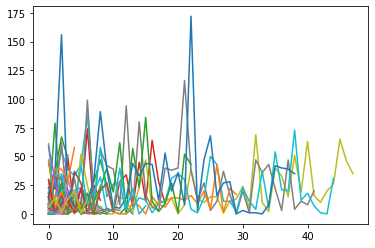

In [112]:
runs=pd.read_csv(args.d+"runs_player_stats.csv")
for p in players.columns[:100]:
    plt.plot(runs[runs[p].notnull()][p].values)
plt.show()

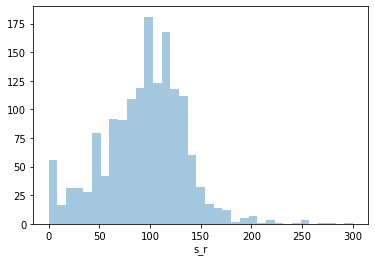

In [122]:
sns.distplot(stats_list["s_r"],kde=False)